# Imports

In [43]:
# %matplotlib notebook
%pip install numpy seaborn matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE

from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.ensemble import IsolationForest as IF
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.mixture import GaussianMixture


https://www.kaggle.com/datasets/ghoshsaibal/creditcard

# Analiza

## Ucitavanje podataka

In [45]:
def csv_to_pd(path):
    return pd.read_csv(path)

def pandas_uniques(df, col_name):
    counts = df[col_name].value_counts()
    unique = df[col_name].unique()
    return unique,counts

def print_uniques(df, cols, count_per_categ=False):
    for c in cols:
        print()
        print(c)
        print("-----------------")
        u, b = pandas_uniques(df,c)
        print("\tVrednosti: ",u)
        print("\tBroj jedinstvenih: ",len(u))
    
        if not count_per_categ: continue
        print("\tJedinstvenih:")
        for i in range(len(b)):
            print("\t",b.iloc[i])
applications = csv_to_pd("./data/application_record.csv")
credits = csv_to_pd("./data/credit_record.csv")

In [46]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [47]:
cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',\
        'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
print_uniques(applications,cols)


CODE_GENDER
-----------------
	Vrednosti:  ['M' 'F']
	Broj jedinstvenih:  2

FLAG_OWN_CAR
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

FLAG_OWN_REALTY
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

NAME_INCOME_TYPE
-----------------
	Vrednosti:  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
	Broj jedinstvenih:  5

NAME_EDUCATION_TYPE
-----------------
	Vrednosti:  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
	Broj jedinstvenih:  5

NAME_FAMILY_STATUS
-----------------
	Vrednosti:  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
	Broj jedinstvenih:  5

NAME_HOUSING_TYPE
-----------------
	Vrednosti:  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
	Broj jedinstvenih:  6

OCCUPATION_TYPE
-----------------
	Vrednosti:  [nan 'Security staff' 'Sales staff' 'Accountants' '

In [48]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [49]:
cols = ['STATUS']
print_uniques(credits,cols)


STATUS
-----------------
	Vrednosti:  ['X' '0' 'C' '1' '2' '3' '4' '5']
	Broj jedinstvenih:  8


## Enkodiranje

In [50]:
def encode_column(df, col_spec):
    df_enc = df.copy()
    for (c, is_one_hot) in col_spec:
        if is_one_hot:
            df_enc = pd.get_dummies(df_enc, columns=[c], dtype=int)
            continue
        le = LabelEncoder()
        le.fit(df_enc[c])
        df_enc[c] = le.transform(df_enc[c])
    return df_enc

def encode_with_dict(df, col, enc_dict):
    df_enc = df.copy()
    df_enc[col] = df_enc[col].apply(lambda x: enc_dict[x])
    return df_enc

In [51]:
cols = [('CODE_GENDER',False),\
        ('FLAG_OWN_CAR',False),\
        ('FLAG_OWN_REALTY',False),\
        ('NAME_INCOME_TYPE',False),\
        ('NAME_EDUCATION_TYPE',False),\
        ('NAME_FAMILY_STATUS', False),\
        ('NAME_HOUSING_TYPE',False),\
        ('OCCUPATION_TYPE',False)]
applications = encode_column(applications, cols)

enc_dict = {'X':-2, 'C':-1, '0':0, '1':1, '2':2, '3':3, '4':4, '5':5}
cred_enc = encode_with_dict(credits, 'STATUS', enc_dict)

## Feature Engineering

In [52]:
# Podelimo zaradu u grupe 
# 20 - 260k na po 20k, sve preko je jedna grupa
def get_bucket(number, bucket_size, max_value, red_one):
    number = min(number,max_value)
    s = number//bucket_size
    return s - 1 if red_one else s

In [53]:
# Dane od rodjenja, dane zaposljenja prevedemo u godine
applications['DAYS_OLD'] = -applications['DAYS_BIRTH']
applications['DAYS_WORKING'] = applications['DAYS_EMPLOYED'].apply(lambda x: -x if x<0 else 0)
applications['INCOME_BRACKET'] = applications['AMT_INCOME_TOTAL'].apply(lambda x: get_bucket(x,20000,1000000,False))

In [54]:
applications.drop(['DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL'],axis=1, inplace=True)

In [55]:
applications.describe()

ID    CODE_GENDER   FLAG_OWN_CAR  FLAG_OWN_REALTY  \
count  4.385570e+05  438557.000000  438557.000000    438557.000000   
mean   6.022176e+06       0.328616       0.371897         0.693351   
std    5.716370e+05       0.469711       0.483312         0.461103   
min    5.008804e+06       0.000000       0.000000         0.000000   
25%    5.609375e+06       0.000000       0.000000         0.000000   
50%    6.047745e+06       0.000000       0.000000         1.000000   
75%    6.456971e+06       1.000000       1.000000         1.000000   
max    7.999952e+06       1.000000       1.000000         1.000000   

        CNT_CHILDREN  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
count  438557.000000     438557.000000        438557.000000   
mean        0.427390          2.399533             3.116268   
std         0.724882          1.730260             1.336736   
min         0.000000          0.000000             0.000000   
25%         0.000000          1.000000             1.000000   
50%         0.000000          4.000000             4.000000   
75%         1.000000          4.000000             4.000000   
max        19.000000          4.000000             4.000000   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  \
count       438557.000000      438557.000000    438557.0    438557.000000   
mean             1.365485           1.261651         1.0         0.206133   
std              0.959034           0.906544         0.0         0.404527   
min              0.000000           0.000000         1.0         0.000000   
25%              1.000000           1.000000         1.0         0.000000   
50%              1.000000           1.000000         1.0         0.000000   
75%              1.000000           1.000000         1.0         0.000000   
max              4.000000           5.000000         1.0         1.000000   

          FLAG_PHONE     FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
count  438557.000000  438557.000000    438557.000000    438557.000000   
mean        0.287771       0.108207        10.828385         2.194465   
std         0.452724       0.310642         5.974606         0.897207   
min         0.000000       0.000000         0.000000         1.000000   
25%         0.000000       0.000000         6.000000         2.000000   
50%         0.000000       0.000000        10.000000         2.000000   
75%         1.000000       0.000000        18.000000         3.000000   
max         1.000000       1.000000        18.000000        20.000000   

            DAYS_OLD   DAYS_WORKING  INCOME_BRACKET  
count  438557.000000  438557.000000   438557.000000  
mean    15997.904649    2172.502516        8.881479  
std      4185.030007    2397.398738        5.013303  
min      7489.000000       0.000000        1.000000  
25%     12514.000000     371.000000        6.000000  
50%     15630.000000    1467.000000        8.000000  
75%     19483.000000    3103.000000       11.000000  
max     25201.000000   17531.000000       50.000000

In [56]:
payment_history = cred_enc[cred_enc['ID'].isin(applications['ID'])]
ids = list(payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict().keys())
applications = applications[applications['ID'].isin(ids)]


## Outlieri

In [57]:
def plot_outliers_cols(data, col1, col2, outliers):
    color_map = {1: 'blue', -1: 'red'}
    colors = [color_map[i] for i in outliers]

    plt.scatter(data[col1], data[col2], c=colors, alpha=0.1)

    plt.xlabel(col1)
    plt.ylabel(col2)

    plt.show()

def plot_outliers(X, y, outliers):
    color_map = {1: 'blue', -1: 'red'}
    colors = [color_map[i] for i in outliers]

    plt.scatter(X, y, c=colors, alpha=0.1)

    plt.show()

### Isolation Forest

In [58]:
isf = IF(n_estimators=1000, n_jobs=-1, contamination=0.1)
pred1 = isf.fit_predict(applications)
c = (pred1<0).sum()
print("Outliers: ",c)

Outliers:  3646


In [59]:
ind = []
for i in range(len(pred1)):
    if pred1[i] == -1:
        ind.append(i)
outliers = applications.iloc[ind]
outliers.describe()

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
count  3.646000e+03  3646.000000   3646.000000      3646.000000   3646.000000   
mean   5.080084e+06     0.504663      0.541690         0.437191      0.918815   
std    4.473817e+04     0.500047      0.498327         0.496107      1.110860   
min    5.008804e+06     0.000000      0.000000         0.000000      0.000000   
25%    5.041326e+06     0.000000      0.000000         0.000000      0.000000   
50%    5.089274e+06     1.000000      1.000000         0.000000      0.000000   
75%    5.117352e+06     1.000000      1.000000         1.000000      2.000000   
max    5.150326e+06     1.000000      1.000000         1.000000     19.000000   

       NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
count       3646.000000          3646.000000         3646.000000   
mean           2.082830             2.256171            1.526879   
std            1.843908             1.412344            1.077627   
min            0.000000             1.000000            0.000000   
25%            0.000000             1.000000            1.000000   
50%            2.000000             1.000000            1.000000   
75%            4.000000             4.000000            3.000000   
max            4.000000             4.000000            4.000000   

       NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE   FLAG_PHONE  \
count        3646.000000      3646.0      3646.000000  3646.000000   
mean            2.334065         1.0         0.523862     0.552935   
std             1.792310         0.0         0.499499     0.497258   
min             0.000000         1.0         0.000000     0.000000   
25%             1.000000         1.0         0.000000     0.000000   
50%             1.000000         1.0         1.000000     1.000000   
75%             5.000000         1.0         1.000000     1.000000   
max             5.000000         1.0         1.000000     1.000000   

        FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS      DAYS_OLD  \
count  3646.000000      3646.000000      3646.000000   3646.000000   
mean      0.359298         9.254800         2.577894  13581.454196   
std       0.479860         6.007957         1.376800   3607.361821   
min       0.000000         0.000000         1.000000   7489.000000   
25%       0.000000         3.000000         1.000000  10681.000000   
50%       0.000000         8.000000         2.000000  13015.000000   
75%       1.000000        14.000000         4.000000  15581.750000   
max       1.000000        18.000000        20.000000  24737.000000   

       DAYS_WORKING  INCOME_BRACKET  
count   3646.000000     3646.000000  
mean    2705.091882       11.707351  
std     2726.332757        7.691778  
min        0.000000        1.000000  
25%      721.000000        6.000000  
50%     1904.000000       10.000000  
75%     3683.000000       14.000000  
max    15038.000000       50.000000

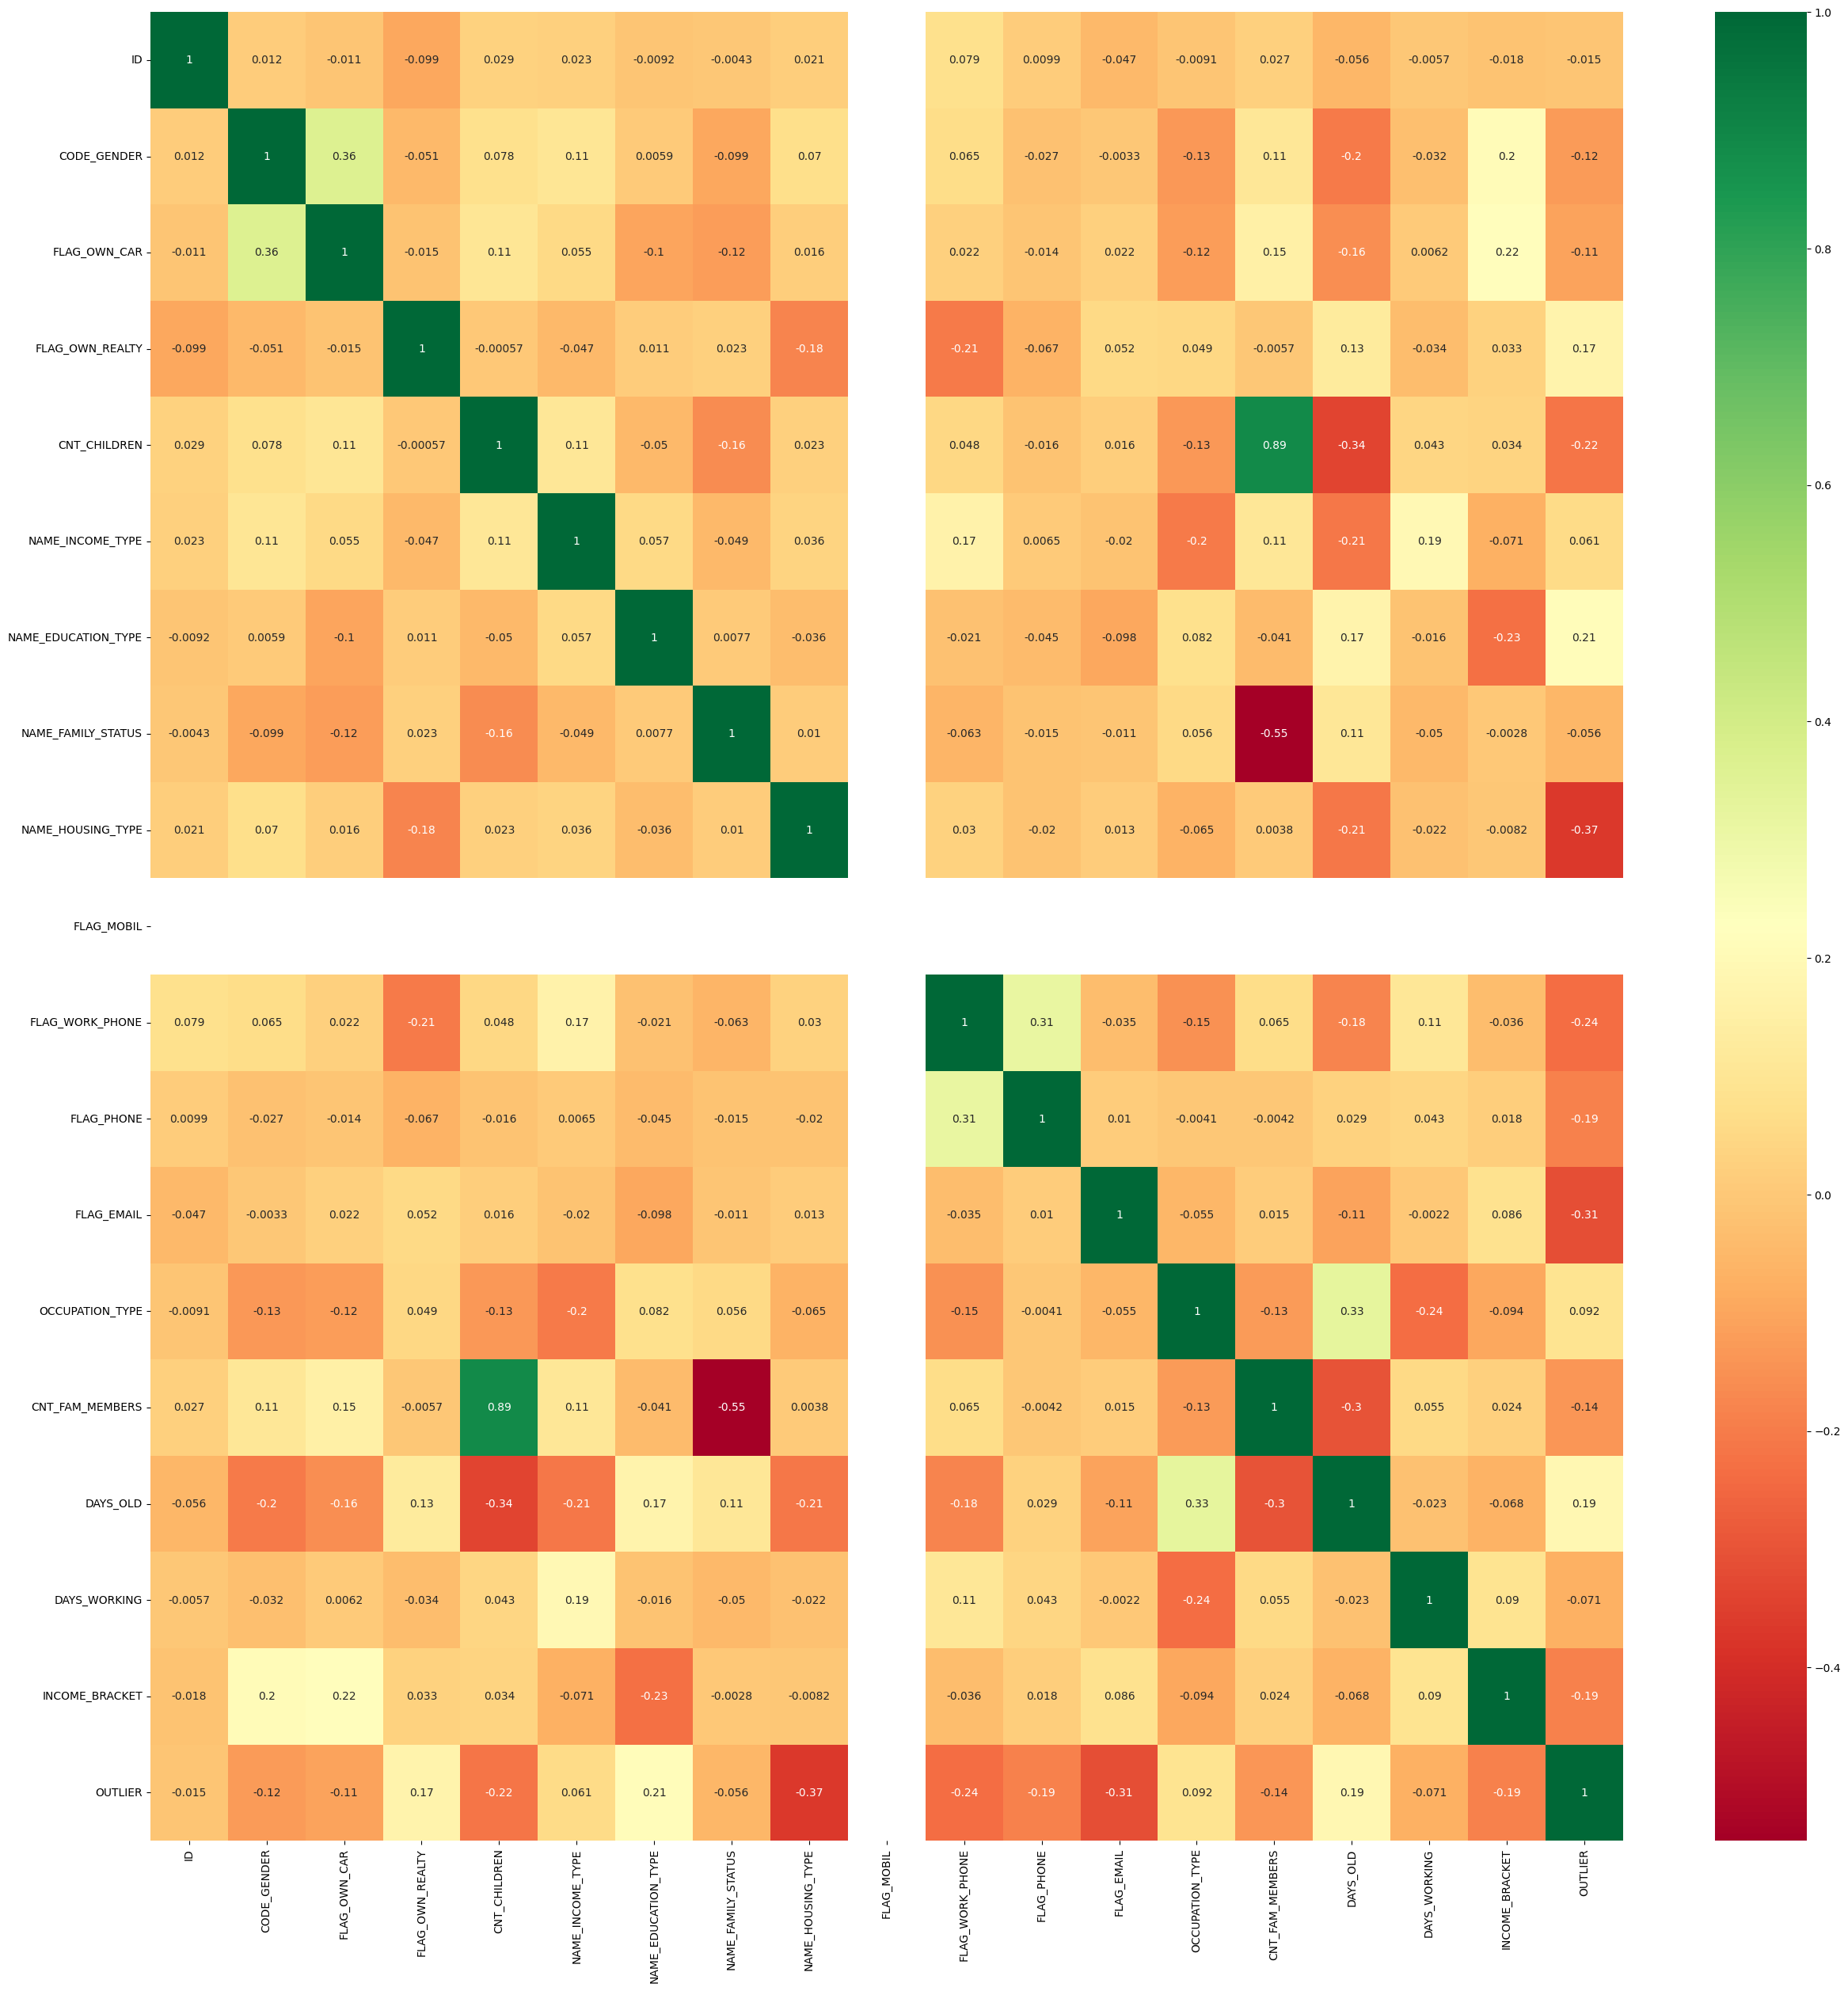

In [60]:
data = applications.copy()
data['OUTLIER'] = pred1
plt.figure(figsize=(30,30))
g=sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

In [61]:
c = data.corr()
c = abs(c['OUTLIER']).sort_values(ascending=False).drop(['OUTLIER','FLAG_MOBIL'])[:8]

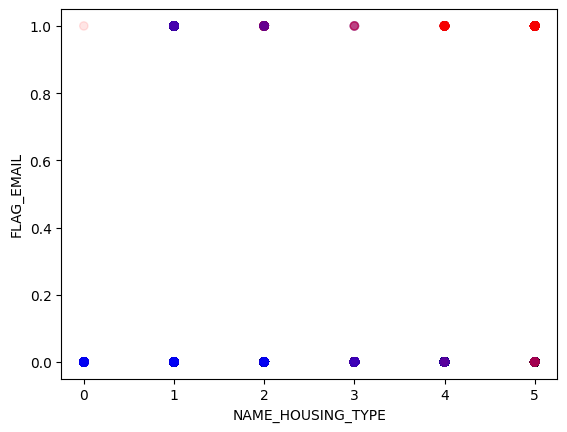

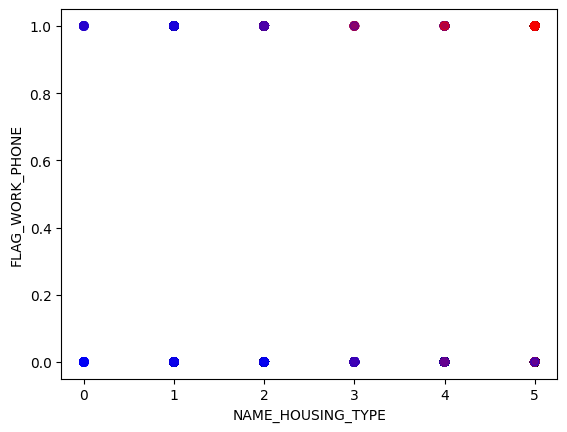

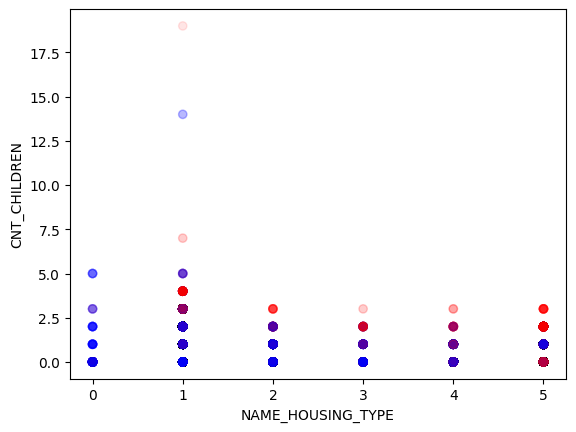

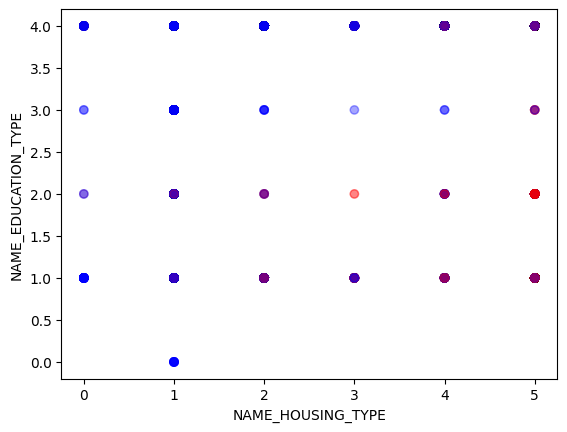

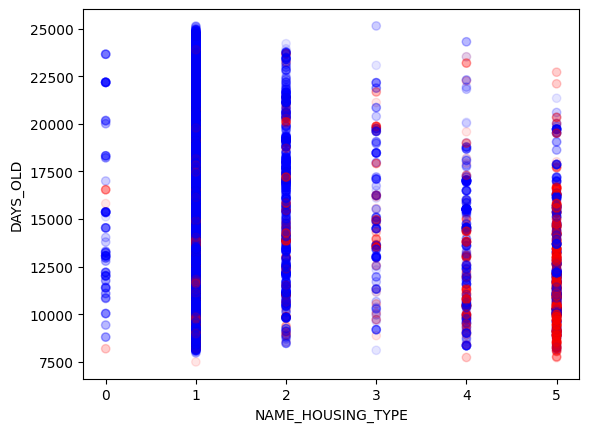

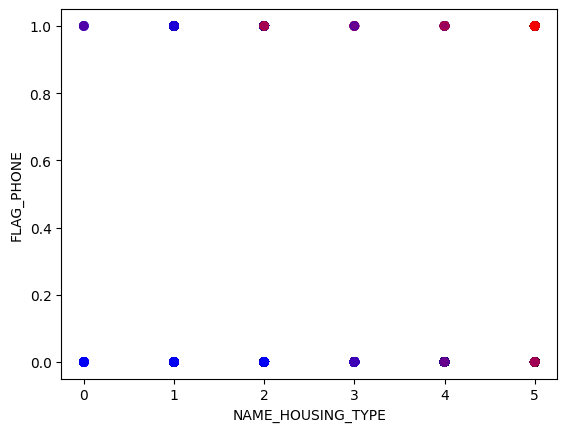

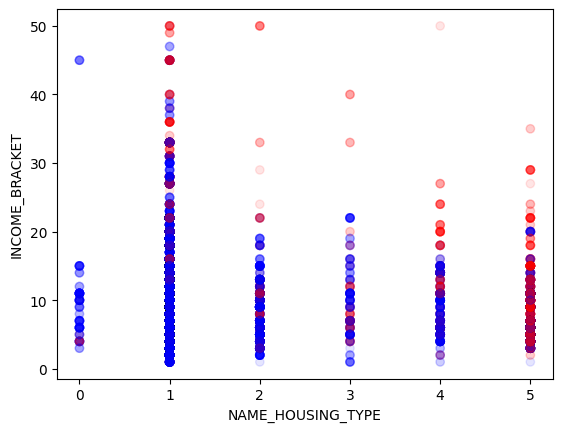

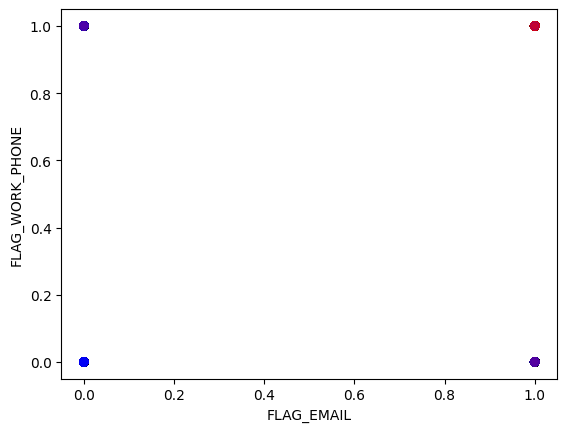

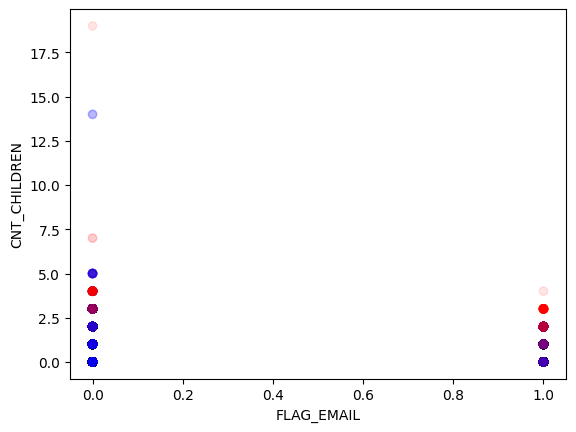

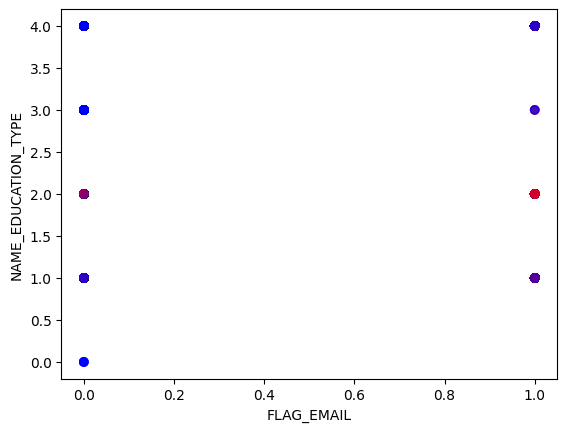

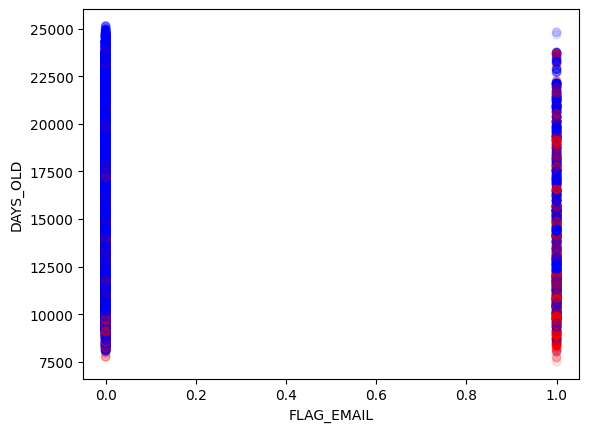

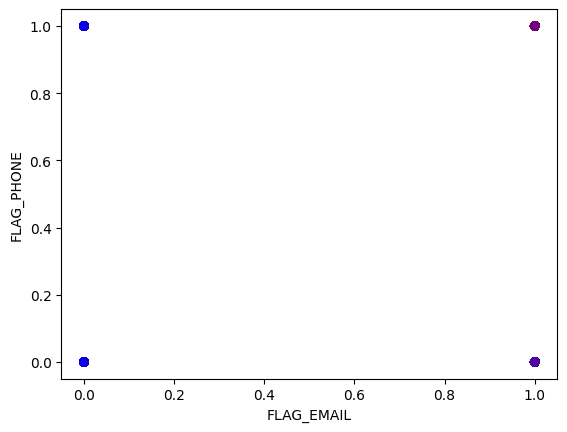

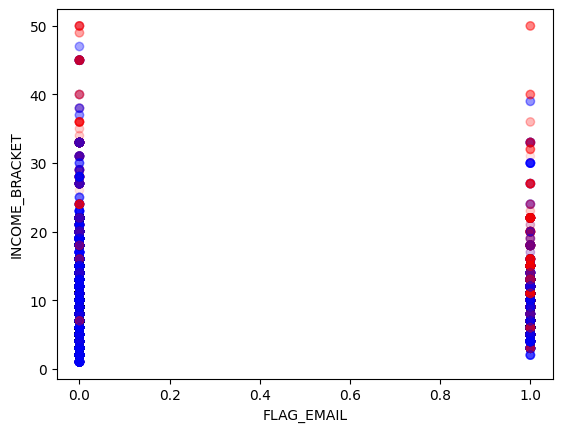

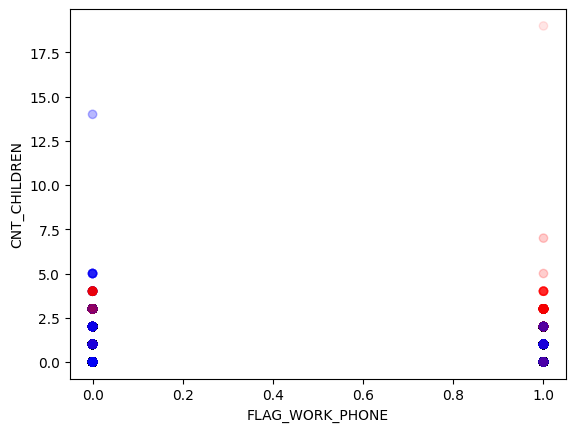

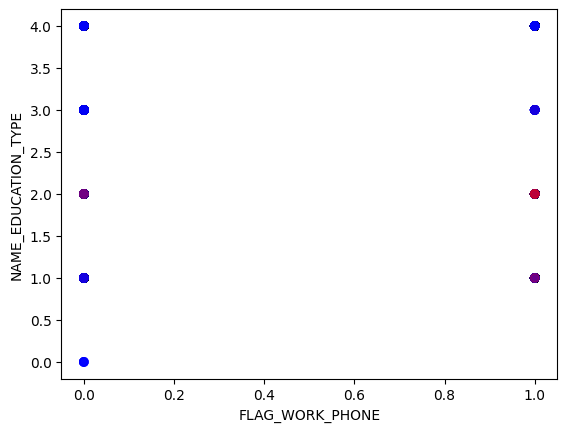

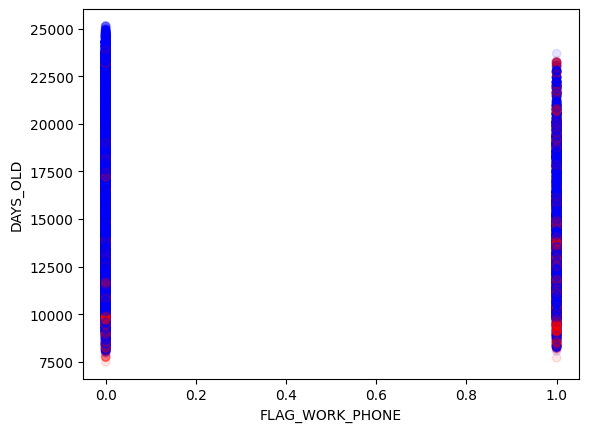

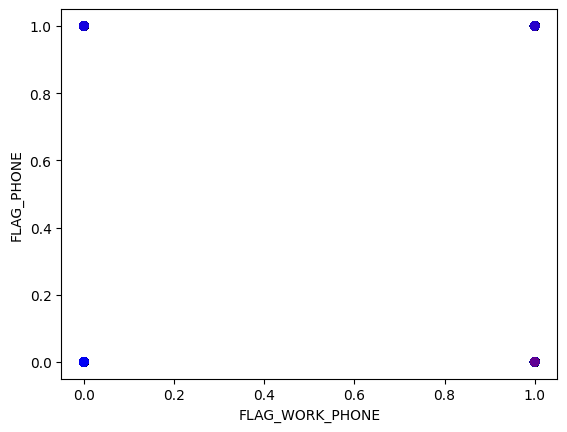

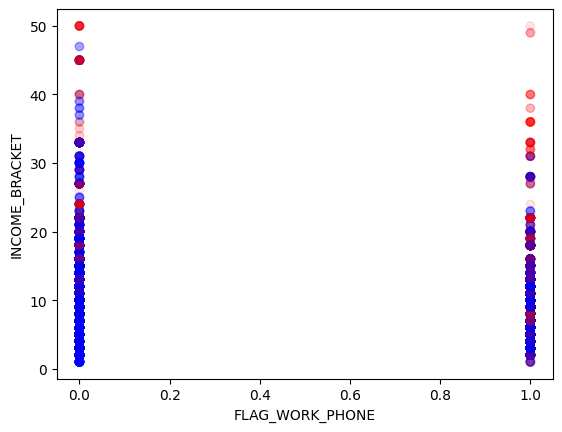

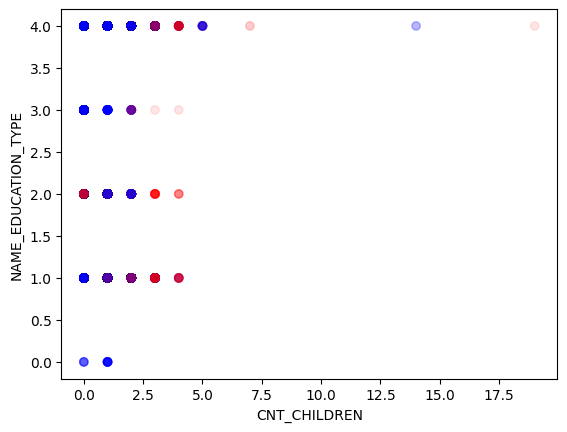

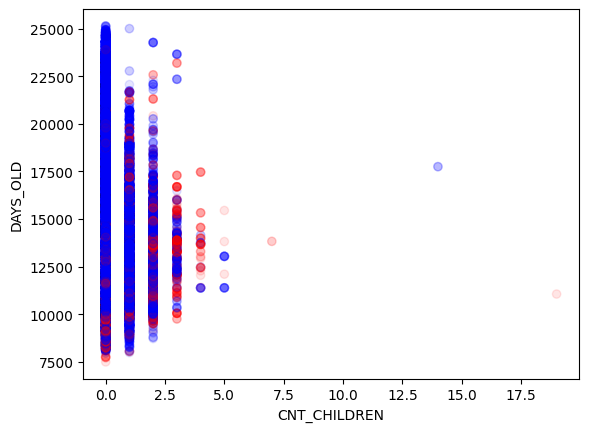

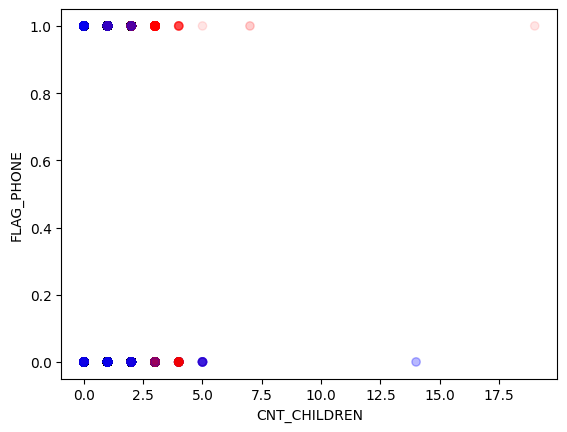

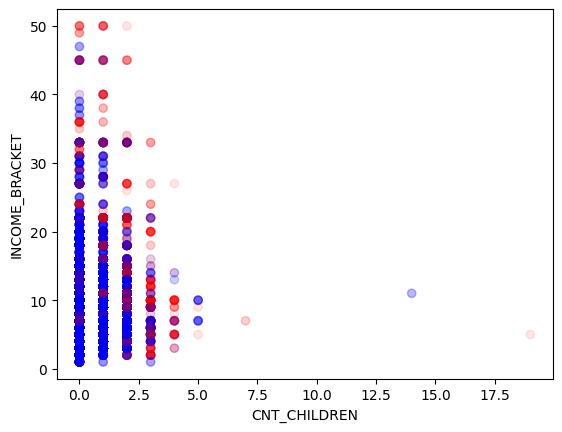

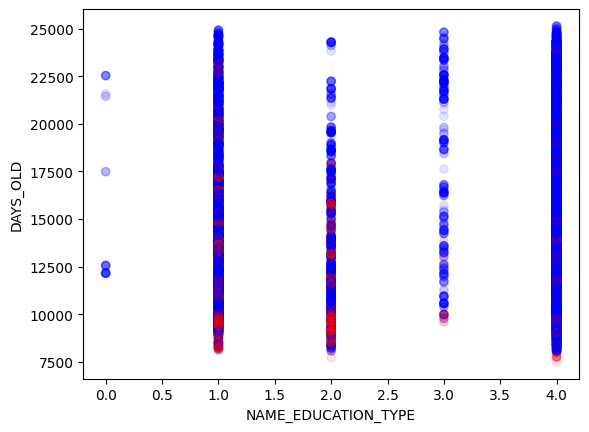

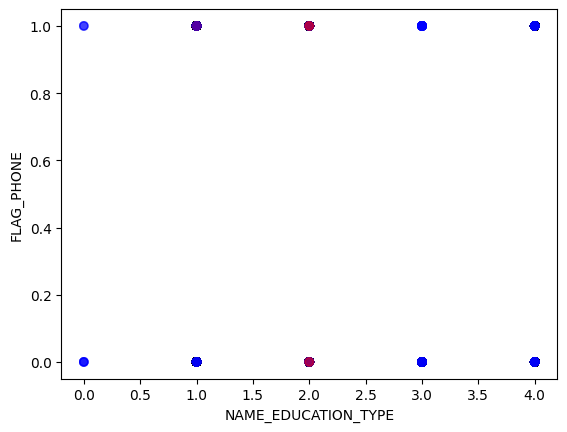

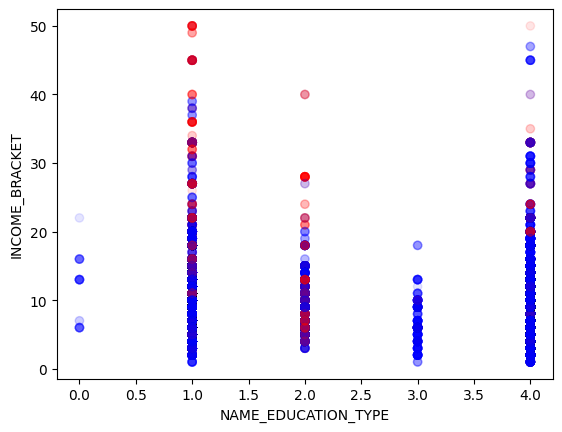

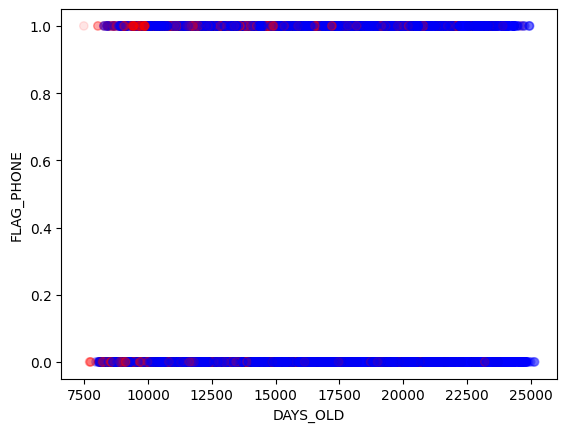

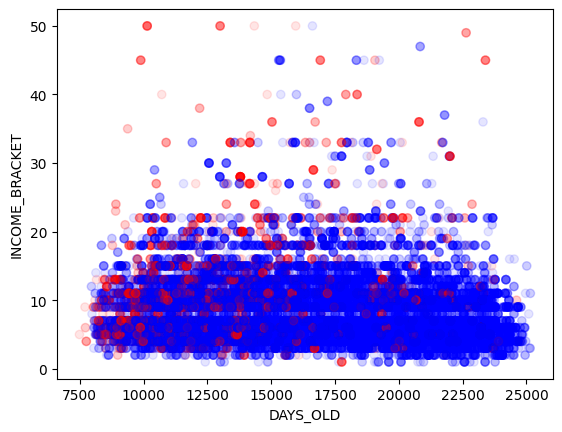

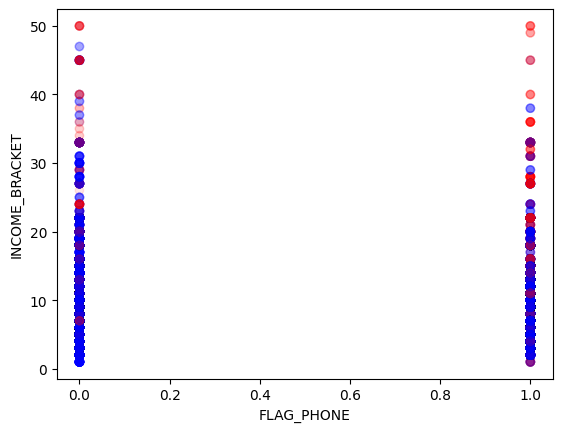

In [62]:
c_names = c.index.to_list()
for i in range(len(c_names)):
    for j in range(i+1,len(c_names)):
        plot_outliers_cols(data = applications, col1 = c_names[i], col2 = c_names[j], outliers = pred1)

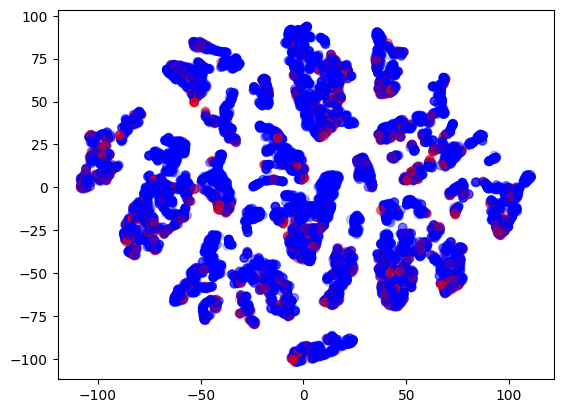

In [63]:
perplexities = [100] #[2,5,30,50,100]
for p in perplexities:
    tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
    tsne_res = tsne.fit_transform(applications)
    tsne_res
    r_T = np.transpose(tsne_res)
    plot_outliers(r_T[0],r_T[1],pred1)

### Local Outlier Factor

In [64]:
lof = LOF(n_neighbors=30, n_jobs=-1)
pred2 = lof.fit_predict(applications)
c = (pred2<0).sum()
print("Outliers: ",c)

Outliers:  998


In [65]:
ind = []
for i in range(len(pred2)):
    if pred2[i] == -1:
        ind.append(i)
outliers = applications.iloc[ind]
outliers.describe()

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
count  9.980000e+02   998.000000    998.000000       998.000000    998.000000   
mean   5.075809e+06     0.348697      0.343687         0.741483      0.256513   
std    4.479198e+04     0.476797      0.475176         0.438039      0.632085   
min    5.008806e+06     0.000000      0.000000         0.000000      0.000000   
25%    5.041261e+06     0.000000      0.000000         0.000000      0.000000   
50%    5.065643e+06     0.000000      0.000000         1.000000      0.000000   
75%    5.116099e+06     1.000000      1.000000         1.000000      0.000000   
max    5.150479e+06     1.000000      1.000000         1.000000      4.000000   

       NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
count        998.000000           998.000000          998.000000   
mean           2.259519             3.097194            1.441884   
std            1.738635             1.340508            1.044703   
min            0.000000             1.000000            0.000000   
25%            0.000000             1.000000            1.000000   
50%            2.000000             4.000000            1.000000   
75%            4.000000             4.000000            1.000000   
max            4.000000             4.000000            4.000000   

       NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
count         998.000000       998.0       998.000000  998.000000  998.000000   
mean            1.208417         1.0         0.199399    0.271543    0.074148   
std             0.828679         0.0         0.399749    0.444978    0.262143   
min             0.000000         1.0         0.000000    0.000000    0.000000   
25%             1.000000         1.0         0.000000    0.000000    0.000000   
50%             1.000000         1.0         0.000000    0.000000    0.000000   
75%             1.000000         1.0         0.000000    1.000000    0.000000   
max             5.000000         1.0         1.000000    1.000000    1.000000   

       OCCUPATION_TYPE  CNT_FAM_MEMBERS      DAYS_OLD  DAYS_WORKING  \
count       998.000000       998.000000    998.000000    998.000000   
mean         11.142285         2.027054  18155.267535   2761.693387   
std           5.974855         0.811323   5038.966974   3150.135756   
min           0.000000         1.000000   7489.000000      0.000000   
25%           6.000000         2.000000  13648.000000    473.000000   
50%          11.000000         2.000000  19961.000000   1812.000000   
75%          18.000000         2.000000  22631.250000   3760.000000   
max          18.000000         6.000000  25099.000000  15661.000000   

       INCOME_BRACKET  
count      998.000000  
mean         9.527054  
std          6.818375  
min          1.000000  
25%          6.000000  
50%          8.000000  
75%         11.000000  
max         49.000000

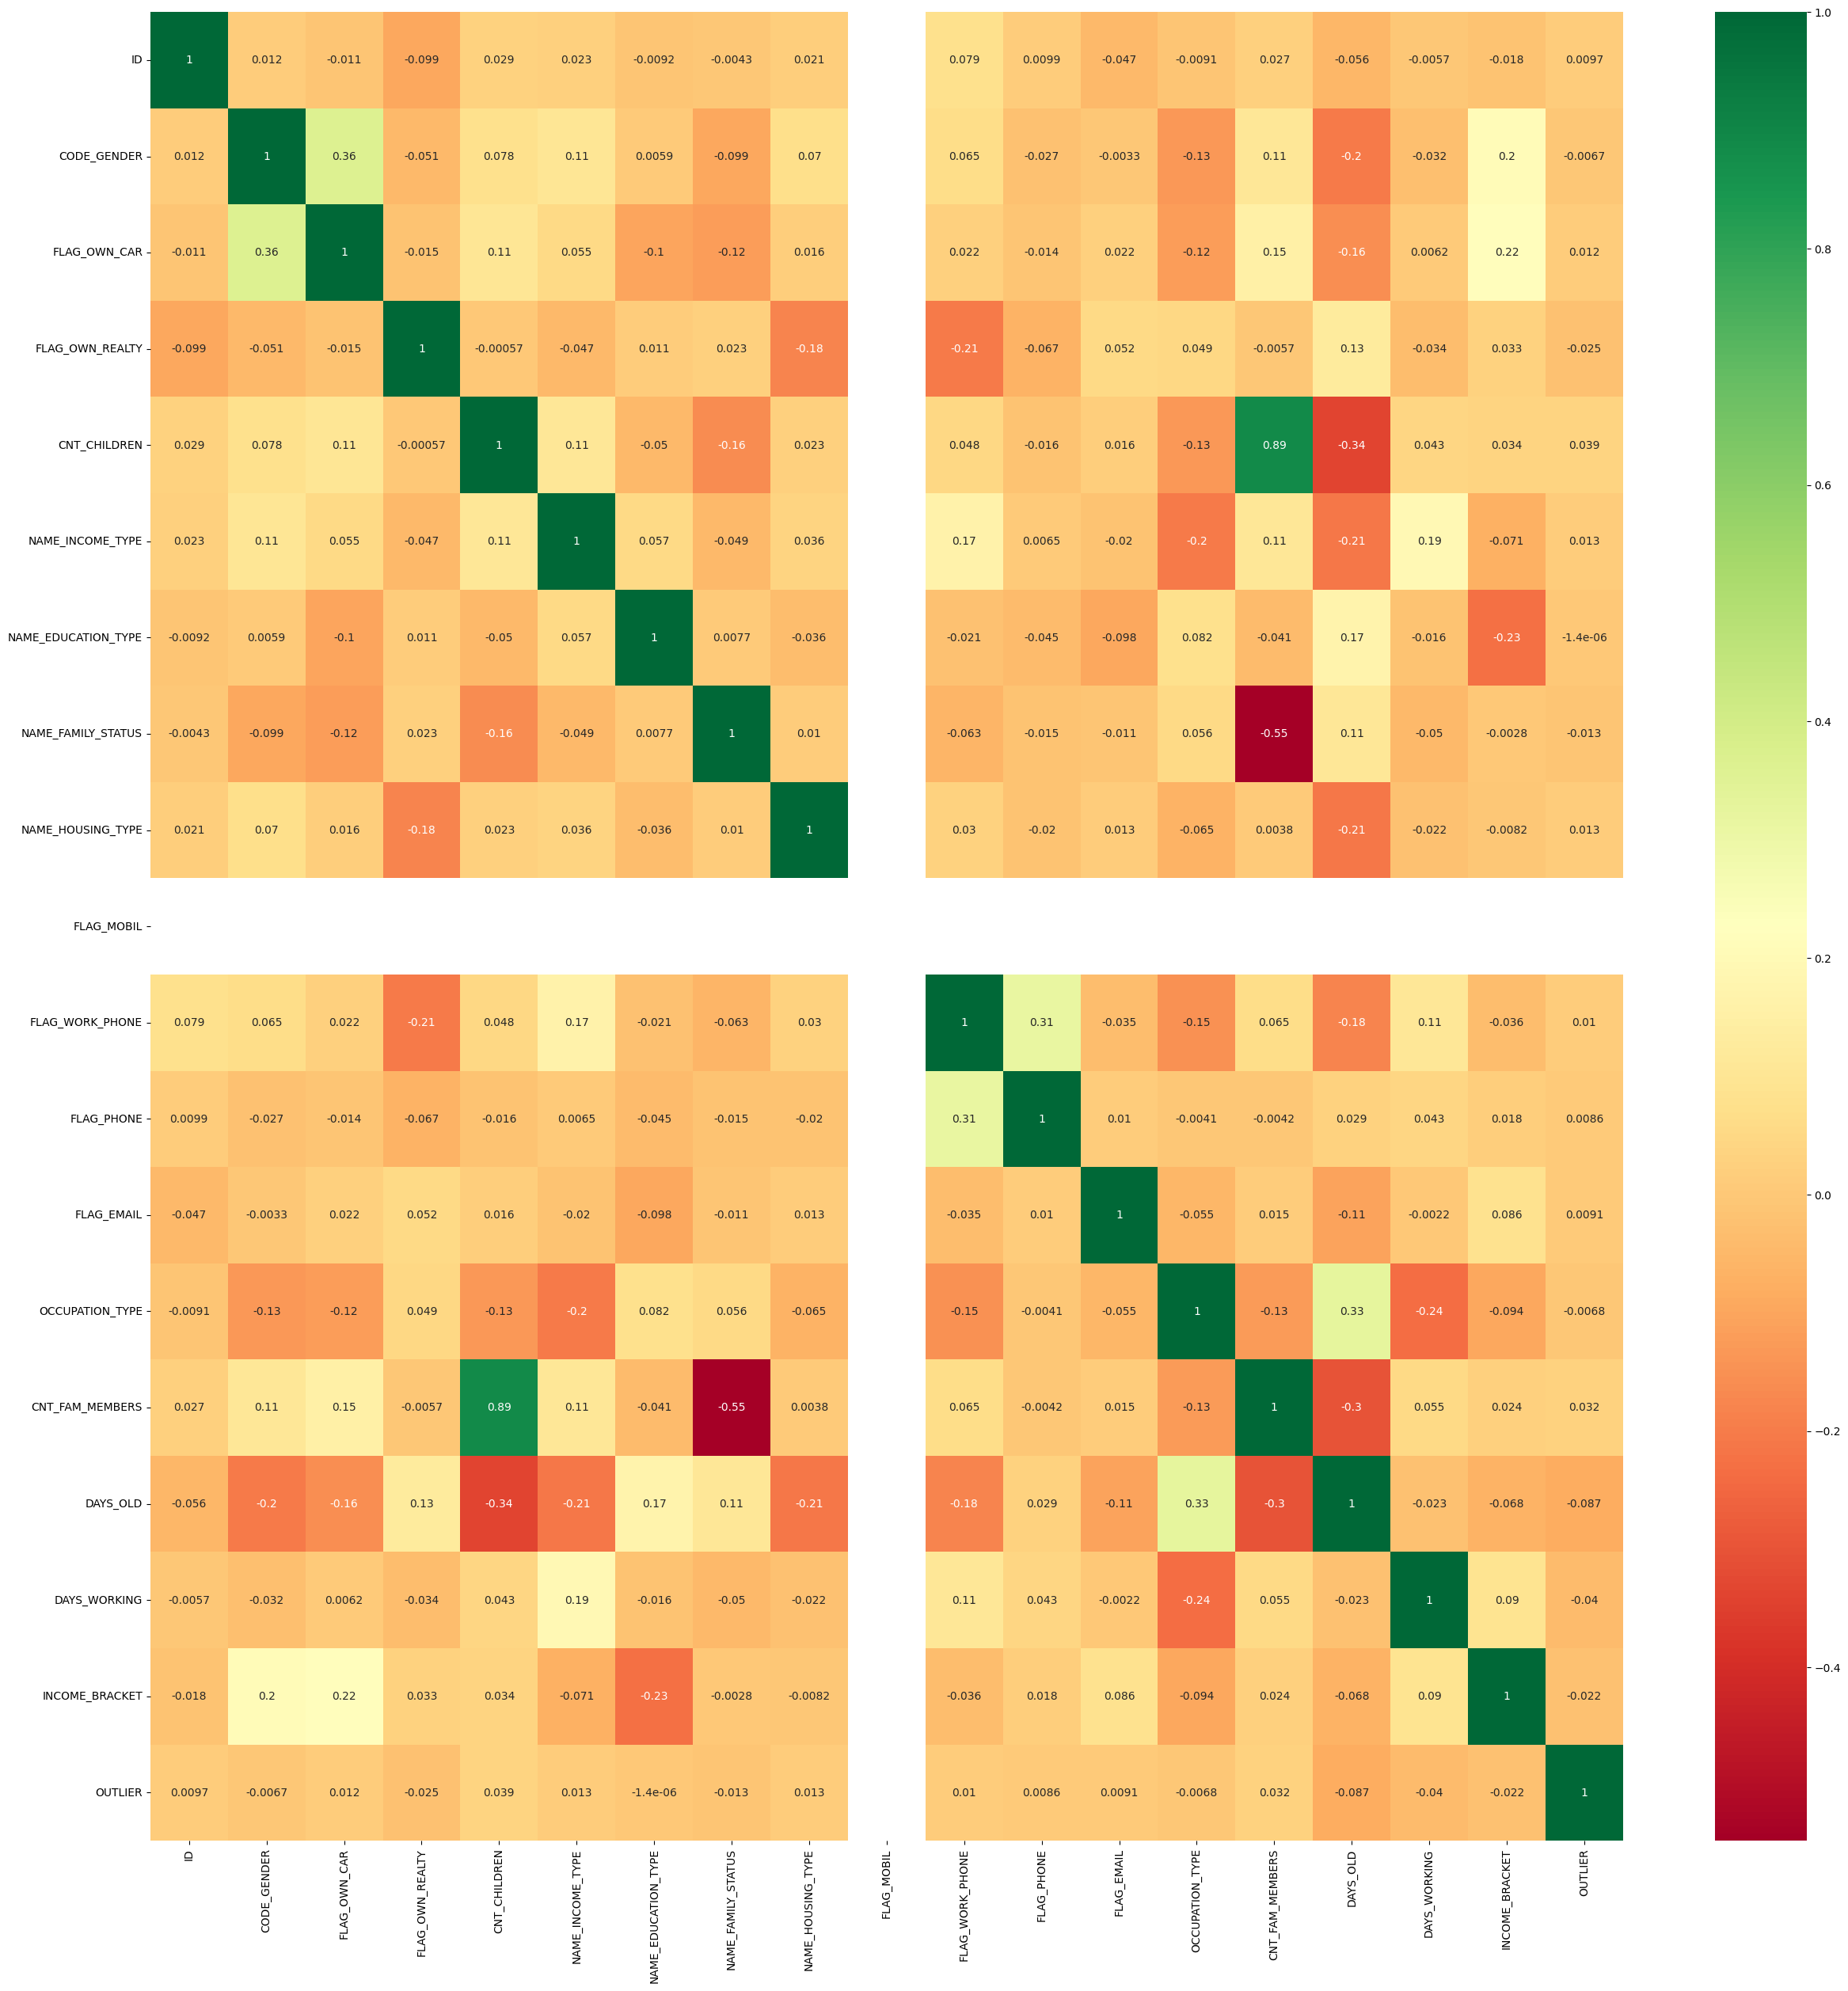

In [66]:
data = applications.copy()
data['OUTLIER'] = pred2
plt.figure(figsize=(30,30))
g=sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

In [67]:
c = data.corr()
c = abs(c['OUTLIER']).sort_values(ascending=False).drop(['OUTLIER','FLAG_MOBIL'])[:8]

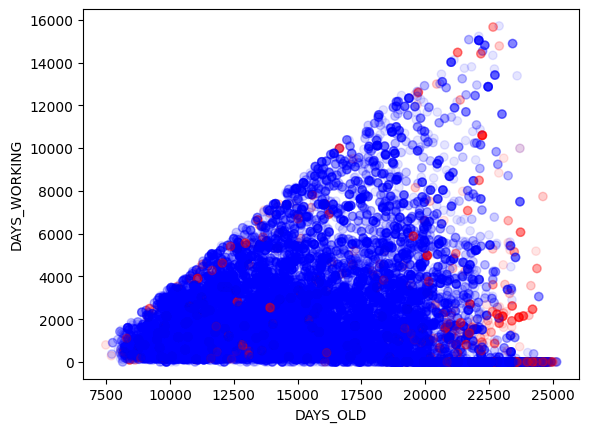

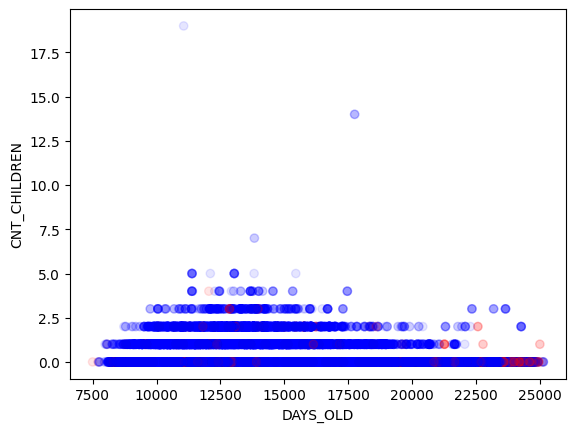

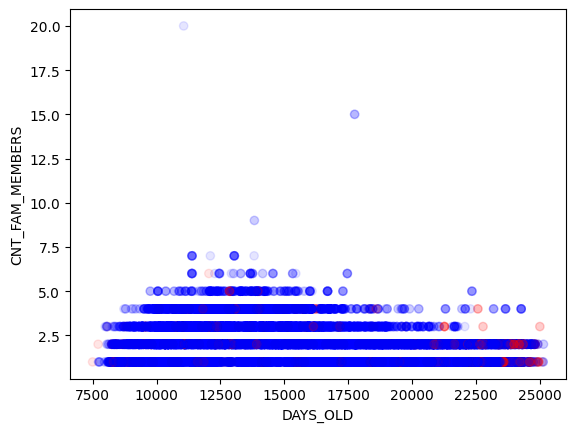

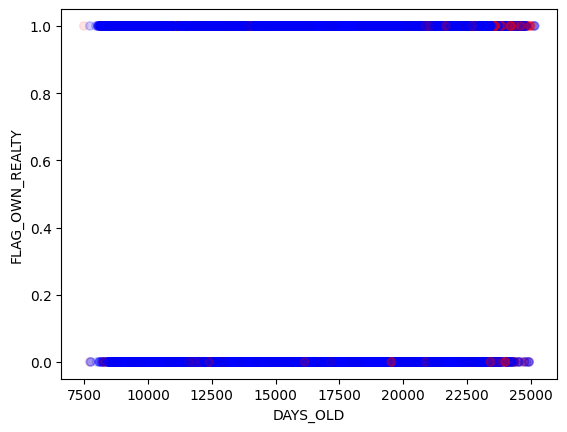

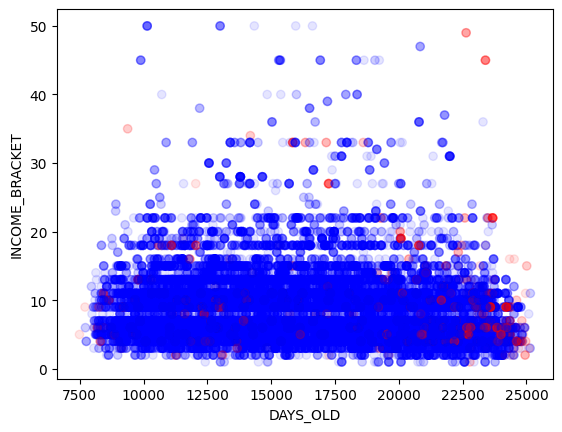

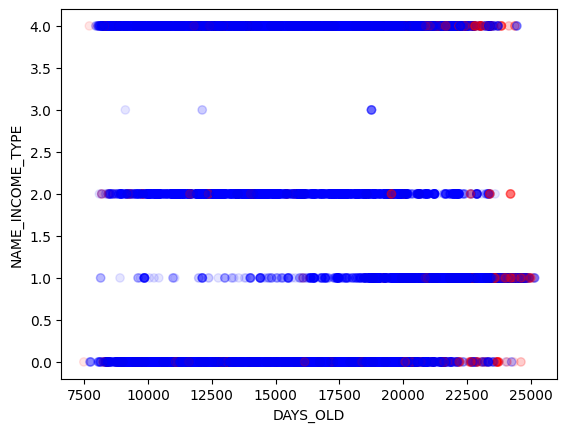

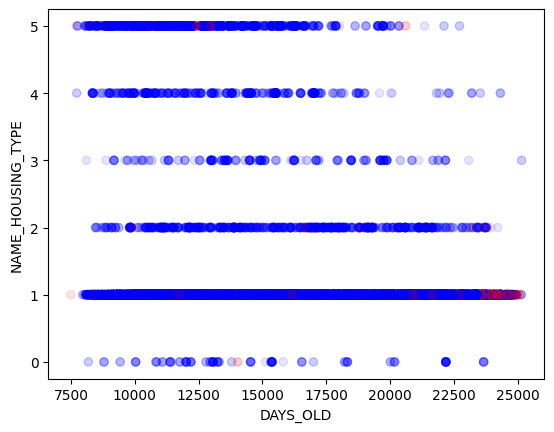

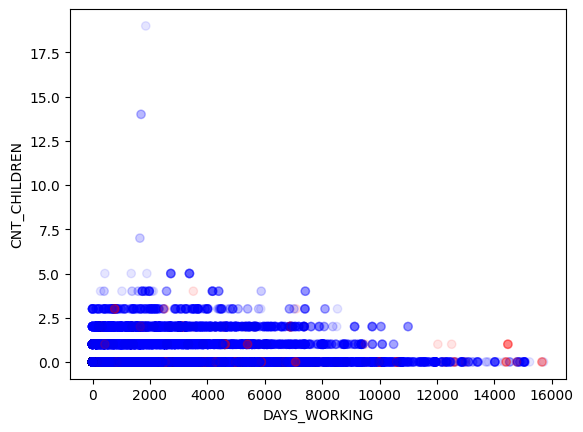

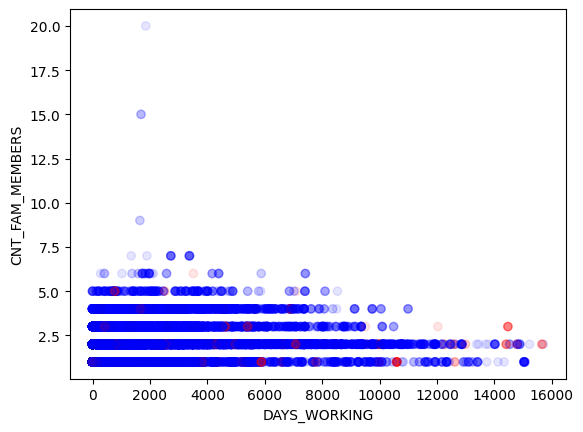

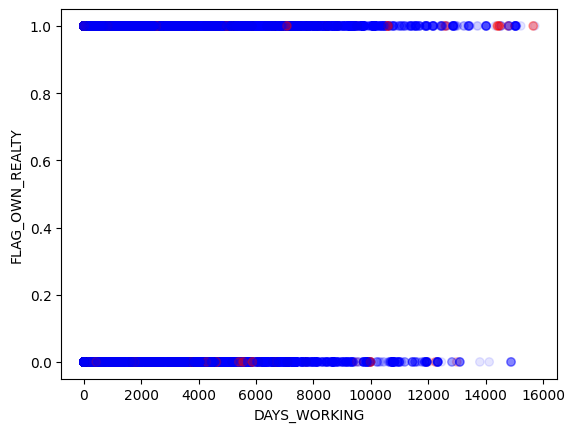

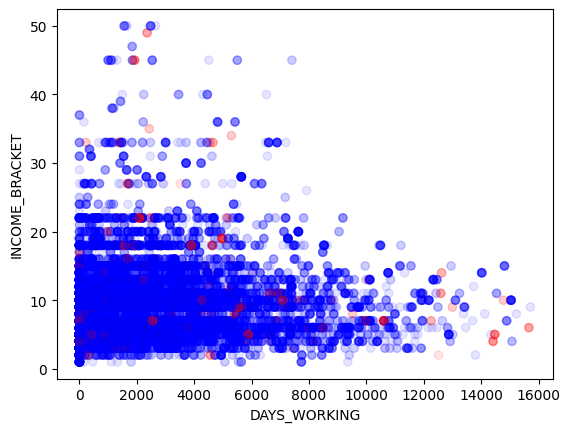

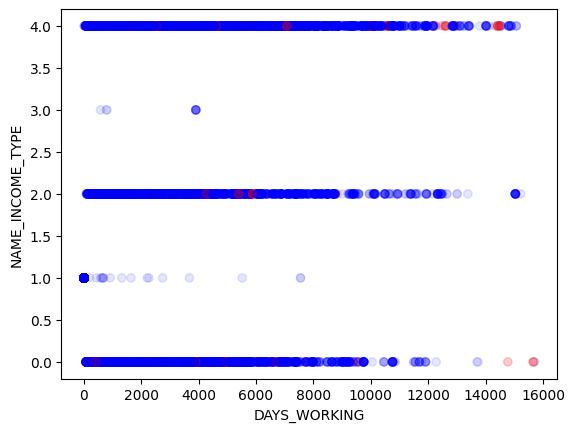

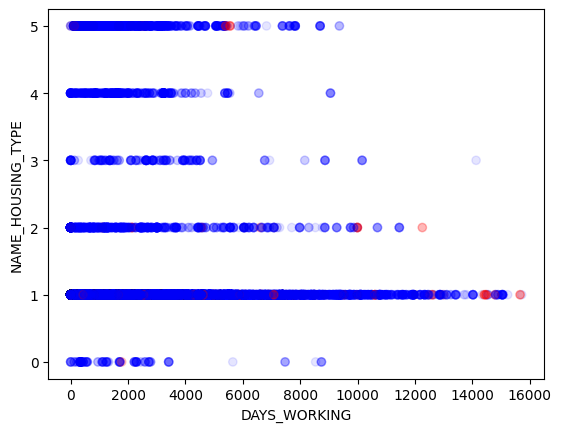

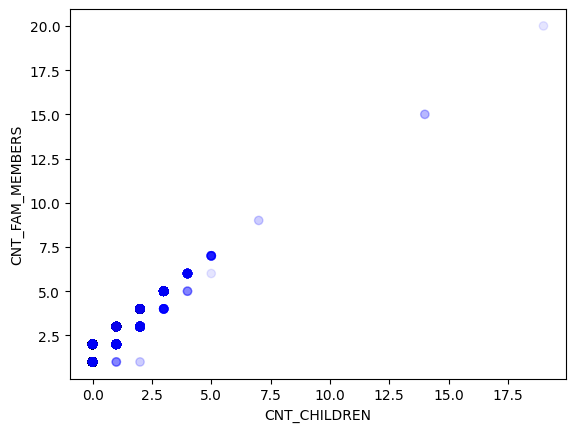

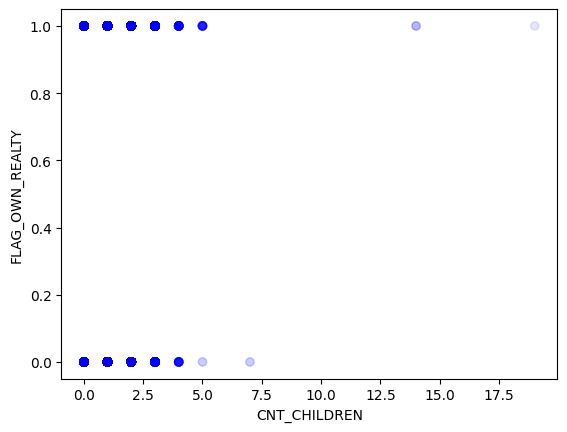

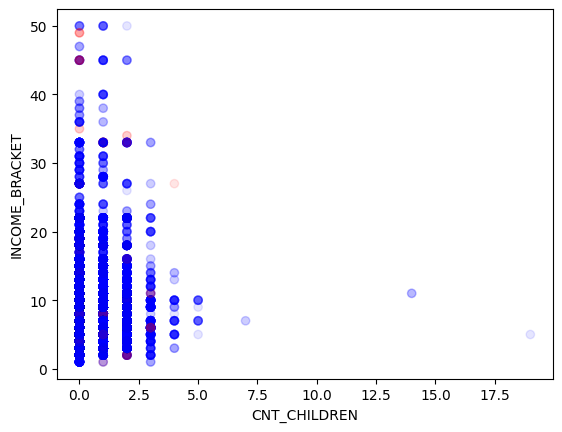

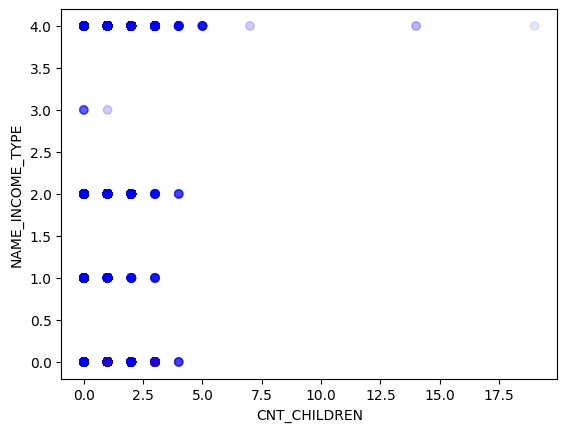

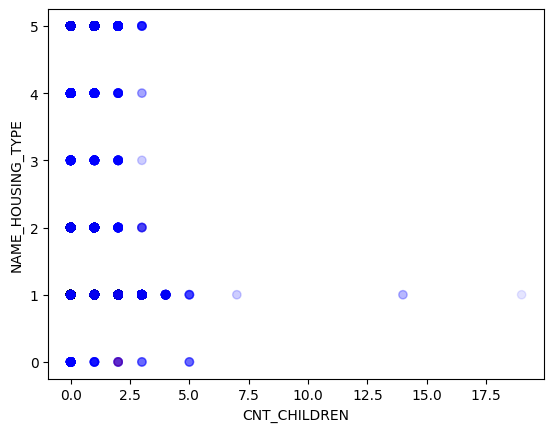

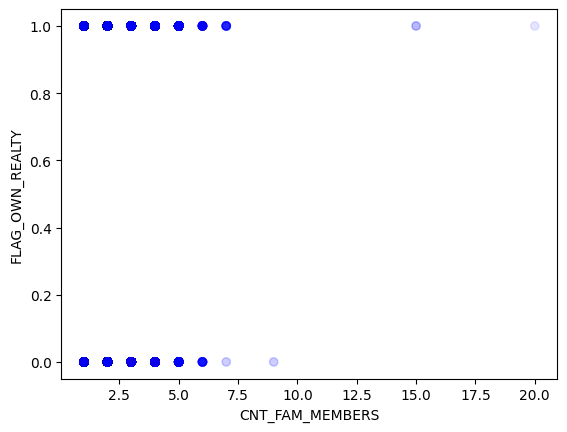

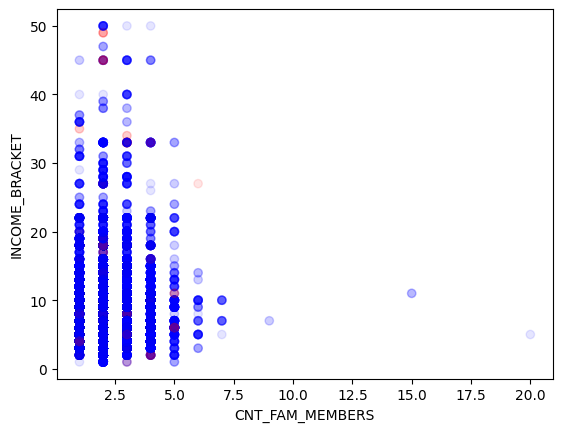

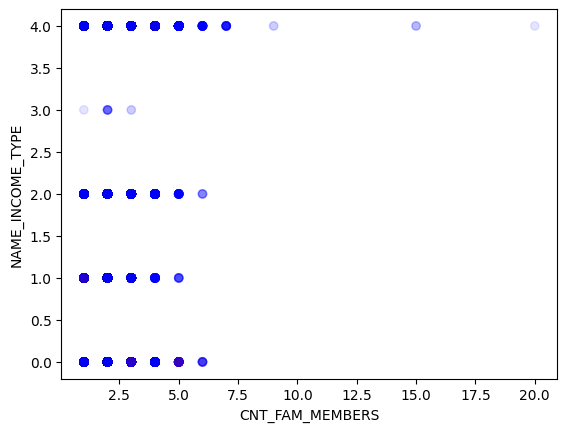

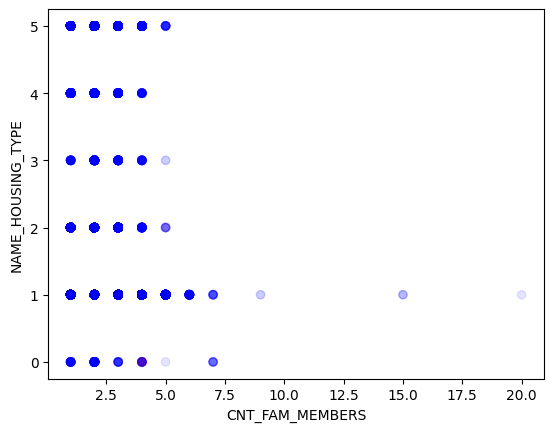

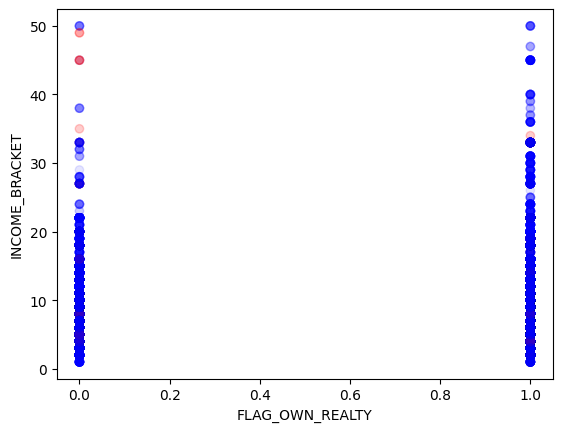

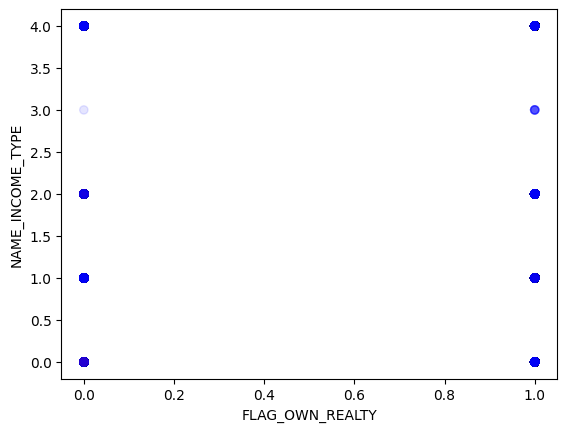

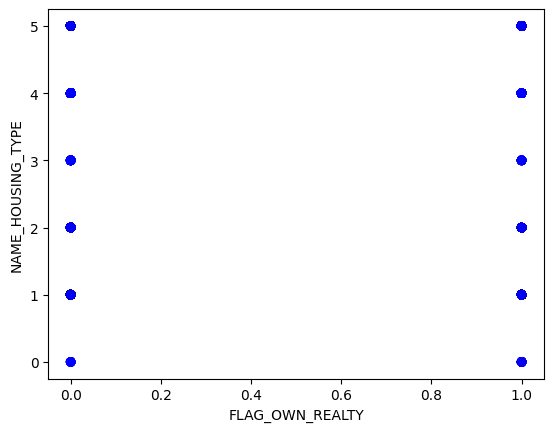

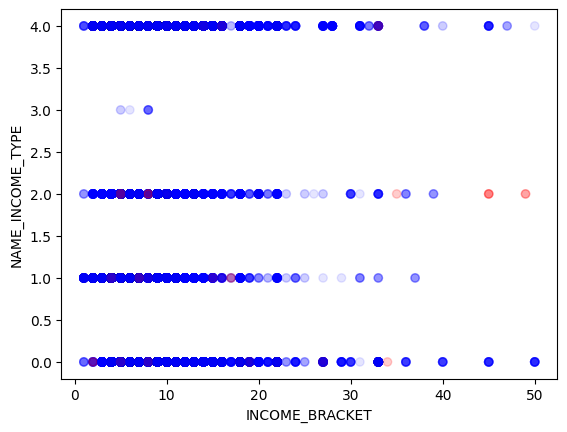

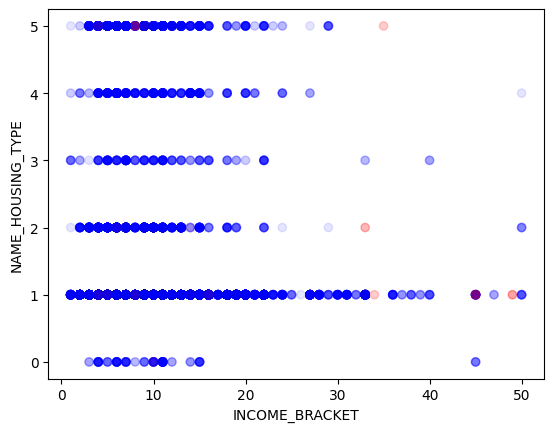

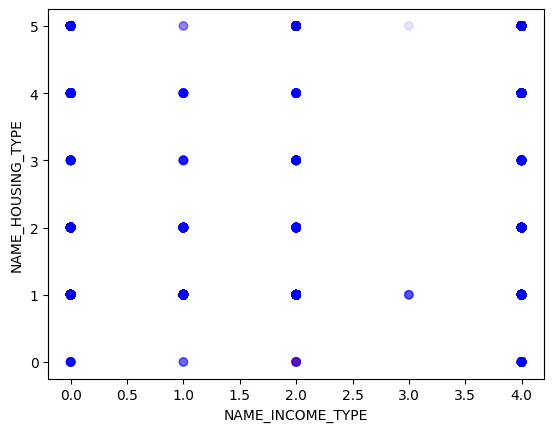

In [68]:
c_names = c.index.to_list()
for i in range(len(c_names)):
    for j in range(i+1,len(c_names)):
        plot_outliers_cols(applications, c_names[i], c_names[j], pred2)

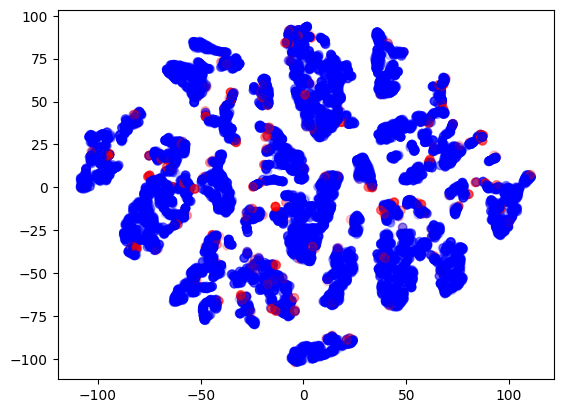

In [69]:
perplexities = [100] #[2,5,30,50,100]
for p in perplexities:
    tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
    tsne_res = tsne.fit_transform(applications)
    tsne_res
    r_T = np.transpose(tsne_res)
    plot_outliers(r_T[0],r_T[1],pred2)

In [70]:
outliers=[]
for i in range(len(pred2)):
    if pred2[i]==-1:
        outliers.append(applications.index[i])
print("Outliers: ", len(outliers))
applications.drop(outliers, inplace=True)
applications

Outliers:  998


ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804            1             1                1             0   
1       5008805            1             1                1             0   
3       5008808            0             0                1             0   
4       5008809            0             0                1             0   
5       5008810            0             0                1             0   
...         ...          ...           ...              ...           ...   
434808  5149828            1             1                1             0   
434809  5149834            0             0                1             0   
434810  5149838            0             0                1             0   
434811  5150049            0             0                1             0   
434812  5150337            1             0                1             0   

        NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                      4                    1                   0   
1                      4                    1                   0   
3                      0                    4                   3   
4                      0                    4                   3   
5                      0                    4                   3   
...                  ...                  ...                 ...   
434808                 4                    4                   1   
434809                 0                    1                   1   
434810                 1                    1                   1   
434811                 4                    4                   1   
434812                 4                    4                   3   

        NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
0                       4           1                1           0   
1                       4           1                1           0   
3                       1           1                0           1   
4                       1           1                0           1   
5                       1           1                0           1   
...                   ...         ...              ...         ...   
434808                  1           1                0           0   
434809                  1           1                0           1   
434810                  1           1                0           1   
434811                  1           1                0           0   
434812                  4           1                0           0   

        FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  DAYS_OLD  DAYS_WORKING  \
0                0               18              2.0     12005          4542   
1                0               18              2.0     12005          4542   
3                1               14              1.0     19110          3051   
4                1               14              1.0     19110          3051   
5                1               14              1.0     19110          3051   
...            ...              ...              ...       ...           ...   
434808           0               10              2.0     17348          2420   
434809           1               11              2.0     12387          1325   
434810           1               11              2.0     12387          1325   
434811           0               14              2.0     17958           655   
434812           0                8              1.0      9188          1193   

        INCOME_BRACKET  
0                 21.0  
1                 21.0  
3                 13.0  
4                 13.0  
5                 13.0  
...                ...  
434808            15.0  
434809             7.0  
434810             7.0  
434811            14.0  
434812             5.0  

[35459 rows x 18 columns]

## Prikaz

In [71]:
def plot_sub(data, axes, i, j, binwidth, color,title=None):
    m = np.mean(data)
    v = np.var(data)
    ax = get_ax(axes,i,j)

    sns.histplot(data = data, binwidth = binwidth, ax = ax, color=color, legend=False)
    
    ax.axvline(m, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {m:.2f}')
    ax.axvline(m - np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'-1 SD')
    ax.axvline(m + np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'+1 SD')

    if not title is None:
        ax.set_title(title)

def plot_pie(data, ax,col):
    labels = data.unique()
    counts = data.value_counts()
    ax.pie(counts,labels=labels,autopct='%1.1f%%')
    ax.set_title(col)

def get_ax(axes, i, j):
    if not hasattr(axes,'shape'):
        return axes
    elif len(axes.shape) == 1:
        return axes[i]
    else:
        return axes[i,j]
    
def get_plot_w_h(plot_count):
    w = int(plot_count**0.5)
    h = plot_count //w
    if plot_count%w !=0:
        h+=1
    return w,h

def plot_features(X, col_list, plot_w, plot_h):
    #col_list - kolona, sirina binova, boja
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col, bins, color = col_list[ind]
            plot_sub(X[col], axes, i, j, bins, color)
    plt.tight_layout()
    plt.show()

def plot_pie_charts(X, col_list, plot_w, plot_h):
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col = col_list[ind]
            plot_pie(X[col], get_ax(axes, i, j),col)
    plt.tight_layout()
    plt.show()

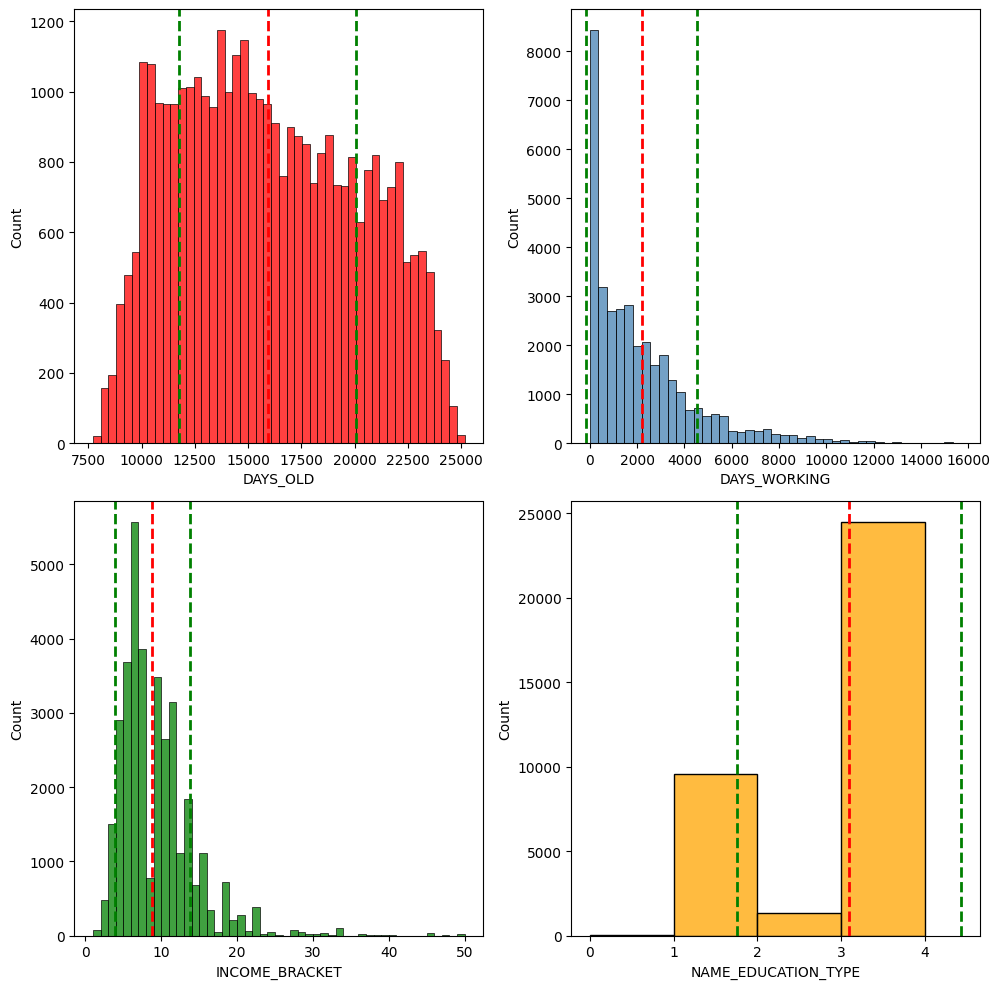

In [72]:
col_list = [('DAYS_OLD',365,'red'),\
            ('DAYS_WORKING',365,'steelblue'),\
            ('INCOME_BRACKET',1,'green'),\
            ('NAME_EDUCATION_TYPE',1,'orange')]
plot_features(applications,col_list,10,10)

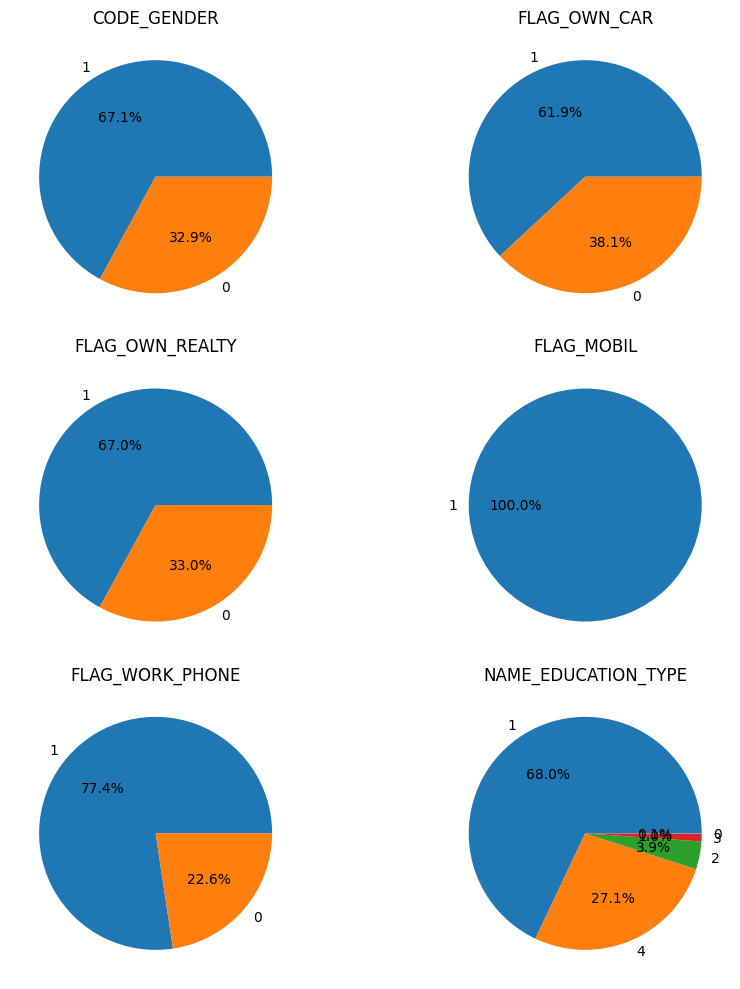

In [73]:
col_list = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_MOBIL','FLAG_WORK_PHONE','NAME_EDUCATION_TYPE']
plot_pie_charts(applications,col_list,10,10)

# Odredjivanje grupe korisnika

In [74]:
# #Nadjemo istoriju placanje za one korisnike ciji ID je u obe tabele
# payment_history = cred_enc[cred_enc['ID'].isin(applications['ID'])]
# #Za svakog korisnika nadjemo status otplate za svaki od meseca, sortiramo i uzmemo samo najnovije podatke
# last_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict()
# avg_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)).to_dict()

In [75]:
# def get_avg_pay(pay_dict):
#     for i in pay_dict.keys():
#         l = pay_dict[i]
#         tot_w = 0
#         s = 0
#         for j in range(len(l)):
#             w = 1/(j+1)
#             s += w * l[j][1]
#             tot_w += w
#         pay_dict[i] = int(s / tot_w)
#     return pay_dict
# avg = list(get_avg_pay(avg_pay_dict).values())
# last = list(last_pay_dict.values())

In [76]:
# ids = list(last_pay_dict.keys())

In [77]:
# apps_with_paydata = applications[applications['ID'].isin(ids)]

## Skaliranje

In [78]:
# ss = StandardScaler()
# applications = ss.fit_transform(applications)

# Redukcija dimenzionalnosti

- DimReduction(tip, broj komp ili ne) -> Clustering (HDBSCAN, KMeans, Agllomerative) -> Viz
    - PCA - 0.95 variance
    - LLE - Tuneuj neighbors i components
    - Bez iceg
- Clustering
    - KMeans - silhoutte graph
    - HDBSCAN 
    - Agglomerative
- Viz
    - TSNE 2d

In [79]:
def get_pcas(min_comp, max_comp, step, out):
    i = min_comp
    while i<=max_comp:
        out.append(("PCA "+str(i)+" variance",PCA(n_components=i)))
        i+=step

def get_lles(min_comp, max_comp, step, min_neigh, max_neigh, neigh_step,out):
    for i in range(min_comp,max_comp,step):
        for j in range(min_neigh, max_neigh,step):
            out.append(("LLE "+str(i)+" components, "+str(j)+" neighbors",LocallyLinearEmbedding(n_components=i, n_jobs=-1, n_neighbors=j, eigen_solver='dense')))

def get_ag(min_cluster, max_cluster, step, out):
    for i in range(min_cluster,max_cluster,step):
        out.append(("AG "+str(i)+" clusters",AgglomerativeClustering(n_clusters=i)))

def plot_clusters(X, y, target, title):
    color_map = {0: 'darkblue', 1: 'red', 2: 'green', 3: 'yellow', 4:'skyblue', 5:'darkorchid', 6:'pink'}
    colors = [color_map[i] for i in target]
    plt.title(title)
    plt.scatter(X, y, c=colors, alpha=0.1)
    plt.show()

def visualize_tsne_clust(data, targets, title):
    perplexities = [100] #[2,5,30,50,100]
    for p in perplexities:
        tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
        tsne_res = tsne.fit_transform(data)
        r_T = np.transpose(tsne_res)
        plot_clusters(r_T[0],r_T[1],targets, title)

def get_hdbscan(out):
    out.append(("HDBSCAN", HDBSCAN()))

def get_kmeans(min_cluster, max_cluster, step, out):
    for i in range(min_cluster,max_cluster,step):
        out.append(("KMeans "+str(i)+" clusters",KMeans(n_clusters=i)))

def execute_pipeline(dim_red, cluster, viz, data):
    red_data = dim_red[1].fit_transform(data)
    title = dim_red[0]+", "+cluster[0]
    clusters  = cluster[1].fit_predict(red_data)
    viz(data, clusters, title)

def pipeline(dim_reds, clusters, viz, data):
    for d in dim_reds:
        for c in clusters:
            execute_pipeline(d,c, viz, data)

In [80]:
dims = []
clusters = []

get_pcas(0.95,0.98,1,dims)
get_lles(3,8,1, 10,11,2,dims)

get_kmeans(3,8,1,clusters)
#get_hdbscan(clusters)
get_ag(3,8,1,clusters)

c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


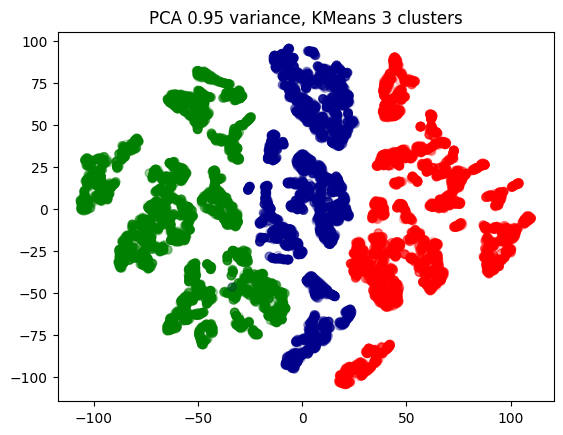

c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


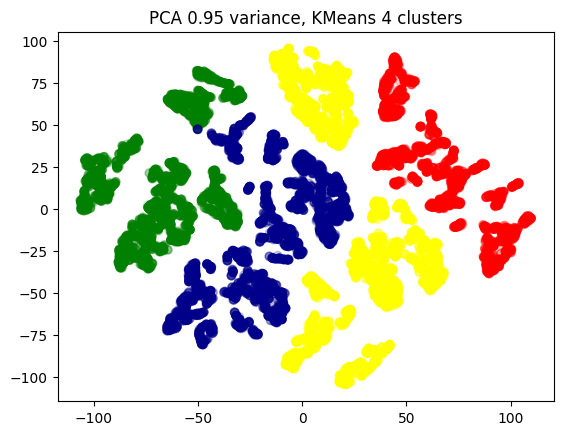

c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


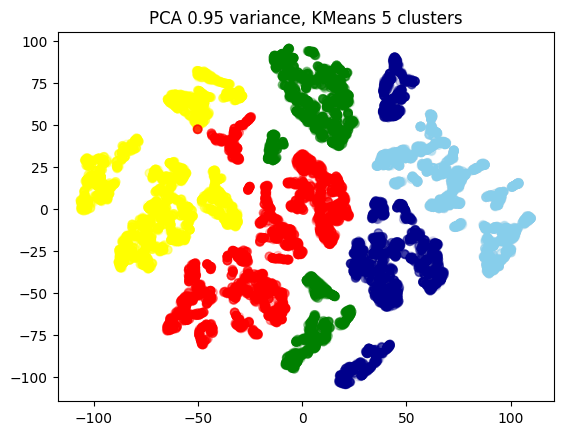

c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


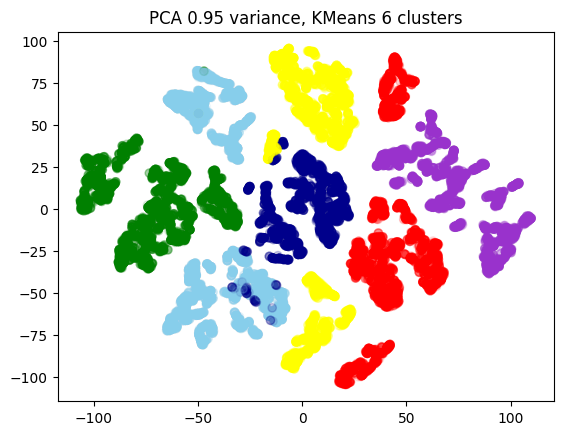

c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


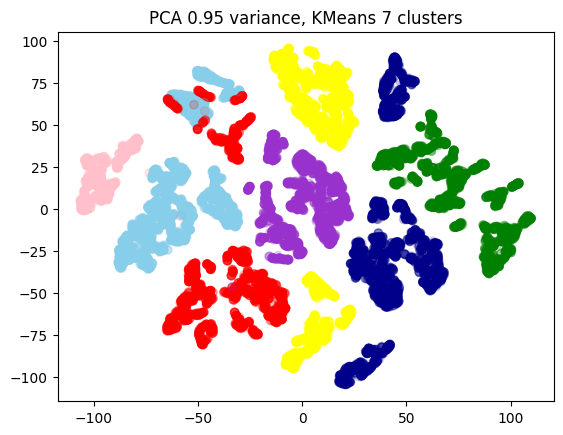

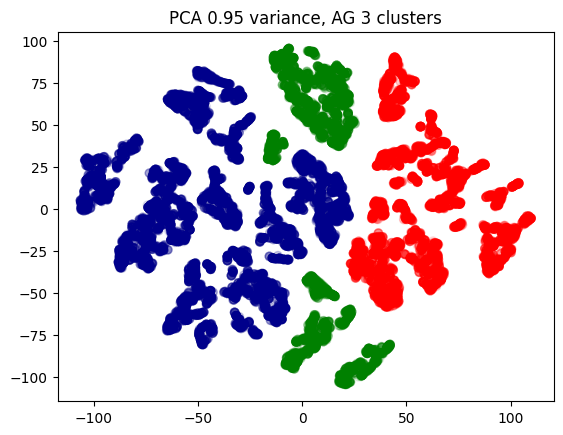

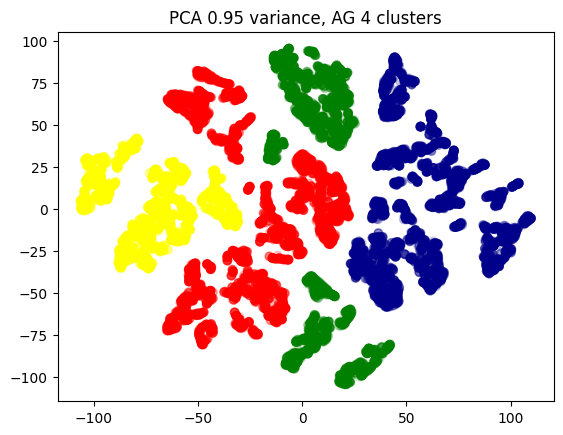

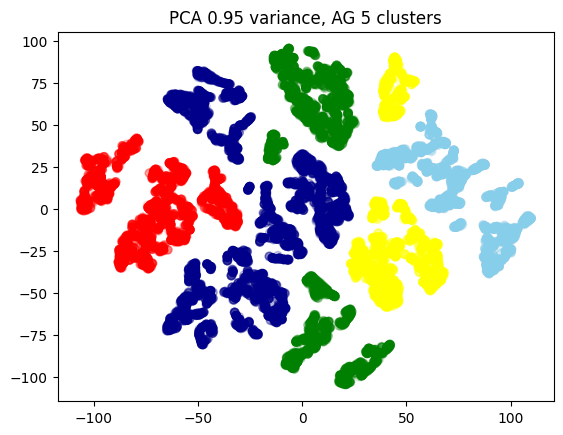

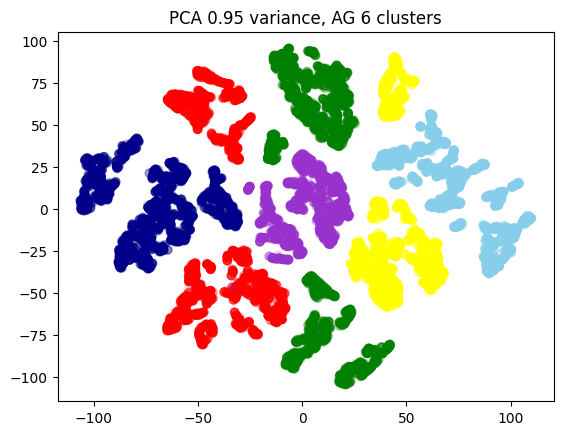

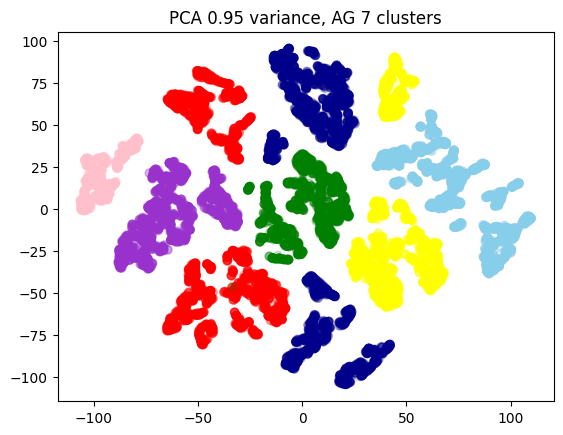

ValueError: Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved. In that case, eigen_solver='dense' is recommended. See online documentation for more information.

In [82]:
pipeline(dims, clusters, visualize_tsne_clust, applications)

In [ ]:
dims = []
clusters = []
get_lles(3,8,1, 10,11,2,dims)

get_kmeans(3,8,1,clusters)
#get_hdbscan(clusters)
get_ag(3,8,1,clusters)

# Clusterovanje

## Vizuelizacija

In [39]:
def transform_with_tsne(data, n_components):
    if n_components>3 or n_components<2:
        print("Bad number of components")
    
    tsne = TSNE(n_components=n_components, n_jobs=-1, verbose = 1, n_iter=1500, perplexity=100, learning_rate=100)
    tsne_res = tsne.fit_transform(data)
    
    return tsne_res
    
def visualise_clusters(data, n_components, labels, title=None):
    fig = plt.figure()
    proj = None if n_components==2 else '3d'
    ax = fig.add_subplot(projection=proj)
    # Scatter plot
    x = data[:,0]
    y = data[:,1]
    z = data[:,2] if n_components==3 else None
    sc = ax.scatter(x, y, z, c=labels, cmap='viridis')  # Adjust size as needed
    cbar = plt.colorbar(sc)
    cbar.set_label('Klasa')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if n_components==3: ax.set_zlabel('Z')
    plt.title('Scatterplot' if title is None else title)
    
    plt.show()

In [40]:
viz_pca_2d = transform_with_tsne(app_train_pca, 2)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 36279 samples in 0.003s...
[t-SNE] Computed neighbors for 36279 samples in 3.005s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36279
[t-SNE] Computed conditional probabilities for sample 2000 / 36279
[t-SNE] Computed conditional probabilities for sample 3000 / 36279
[t-SNE] Computed conditional probabilities for sample 4000 / 36279
[t-SNE] Computed conditional probabilities for sample 5000 / 36279
[t-SNE] Computed conditional probabilities for sample 6000 / 36279
[t-SNE] Computed conditional probabilities for sample 7000 / 36279
[t-SNE] Computed conditional probabilities for sample 8000 / 36279
[t-SNE] Computed conditional probabilities for sample 9000 / 36279
[t-SNE] Computed conditional probabilities for sample 10000 / 36279
[t-SNE] Computed conditional probabilities for sample 11000 / 36279
[t-SNE] Computed conditional probabilities for sample 12000 / 36279
[t-SNE] Computed conditional probabilities for sa

In [41]:
viz_pca_3d = transform_with_tsne(app_train_pca, 3)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 36279 samples in 0.002s...
[t-SNE] Computed neighbors for 36279 samples in 2.607s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36279
[t-SNE] Computed conditional probabilities for sample 2000 / 36279
[t-SNE] Computed conditional probabilities for sample 3000 / 36279
[t-SNE] Computed conditional probabilities for sample 4000 / 36279
[t-SNE] Computed conditional probabilities for sample 5000 / 36279
[t-SNE] Computed conditional probabilities for sample 6000 / 36279
[t-SNE] Computed conditional probabilities for sample 7000 / 36279
[t-SNE] Computed conditional probabilities for sample 8000 / 36279
[t-SNE] Computed conditional probabilities for sample 9000 / 36279
[t-SNE] Computed conditional probabilities for sample 10000 / 36279
[t-SNE] Computed conditional probabilities for sample 11000 / 36279
[t-SNE] Computed conditional probabilities for sample 12000 / 36279
[t-SNE] Computed conditional probabilities for sa

In [42]:
viz_lle_2d = transform_with_tsne(app_train_lle, 2)
viz_lle_3d = transform_with_tsne(app_train_lle, 3)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 36279 samples in 0.002s...
[t-SNE] Computed neighbors for 36279 samples in 2.586s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36279
[t-SNE] Computed conditional probabilities for sample 2000 / 36279
[t-SNE] Computed conditional probabilities for sample 3000 / 36279
[t-SNE] Computed conditional probabilities for sample 4000 / 36279
[t-SNE] Computed conditional probabilities for sample 5000 / 36279
[t-SNE] Computed conditional probabilities for sample 6000 / 36279
[t-SNE] Computed conditional probabilities for sample 7000 / 36279
[t-SNE] Computed conditional probabilities for sample 8000 / 36279
[t-SNE] Computed conditional probabilities for sample 9000 / 36279
[t-SNE] Computed conditional probabilities for sample 10000 / 36279
[t-SNE] Computed conditional probabilities for sample 11000 / 36279
[t-SNE] Computed conditional probabilities for sample 12000 / 36279
[t-SNE] Computed conditional probabilities for sa

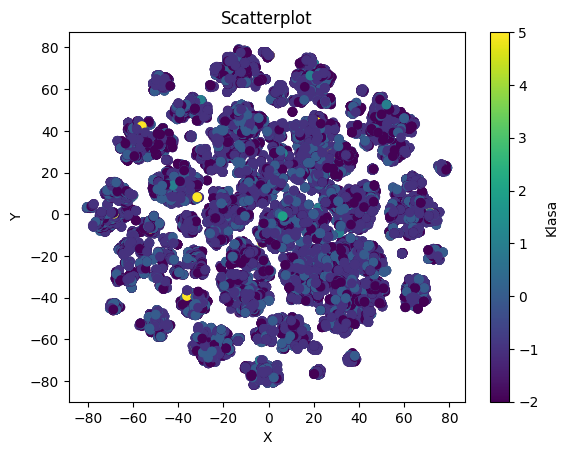

In [43]:
visualise_clusters(viz_pca_2d,2,last)

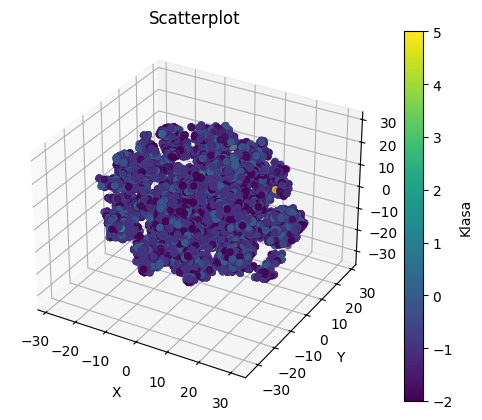

In [44]:
visualise_clusters(viz_pca_3d,3,last)

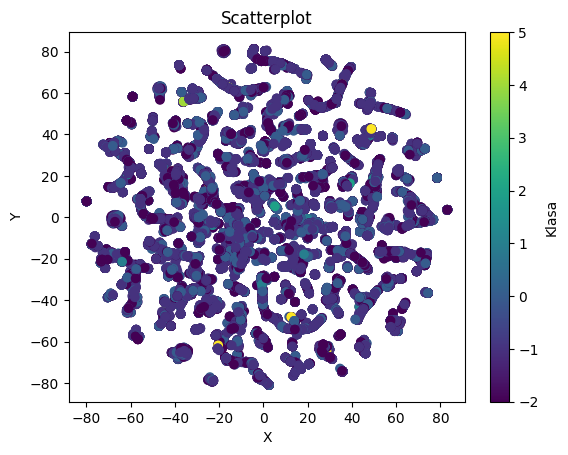

In [45]:
visualise_clusters(viz_lle_2d,2,last)

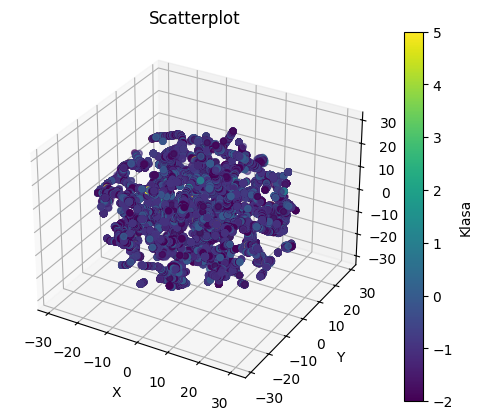

In [46]:
visualise_clusters(viz_lle_3d,3,last)

## Cluster

In [47]:
#KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, HDBSCAN
#GaussianMixture
def get_all_algs():
    algs = {'KM': KMeans(n_clusters=30, verbose=3), \
            'AC': AgglomerativeClustering(n_clusters=30, compute_distances=True), \
            'HD': HDBSCAN(n_jobs=-1),\
            'GM': GaussianMixture(verbose=3)}
    return algs

def train_algs(data, algs, get_preds=False):
    preds = [] 
    keys = list(algs.keys())
    for key in keys:
        try:
            print(key)
            print("------------------")
            p = algs[key].fit_predict(data)
            if get_preds: preds.append(p)
            print("------------------")
        except Exception as e:
            print(e)
    if get_preds:
        return preds

In [48]:
algs = get_all_algs()
preds_pca = train_algs(app_train_pca, algs, True)

KM
------------------
Initialization complete
Iteration 0, inertia 1084237.072172587.
Iteration 1, inertia 775895.5190835922.
Iteration 2, inertia 755575.1759954055.
Iteration 3, inertia 747300.166883765.
Iteration 4, inertia 742758.9466287857.
Iteration 5, inertia 737636.1404679312.
Iteration 6, inertia 722457.8726236874.
Iteration 7, inertia 715532.6710898749.
Iteration 8, inertia 711182.7233560239.
Iteration 9, inertia 711010.2913364035.
Iteration 10, inertia 710922.1929599532.
Iteration 11, inertia 710850.334340928.
Iteration 12, inertia 710761.2671191663.
Iteration 13, inertia 710726.6932555893.
Iteration 14, inertia 710712.5943231786.
Iteration 15, inertia 710711.2903874042.
Iteration 16, inertia 710711.0959035349.
Converged at iteration 16: strict convergence.


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 1085150.781775207.
Iteration 1, inertia 782304.5722344238.
Iteration 2, inertia 756201.1124513422.
Iteration 3, inertia 740416.9155151071.
Iteration 4, inertia 735007.709197002.
Iteration 5, inertia 734555.5563523895.
Iteration 6, inertia 734395.7299641721.
Iteration 7, inertia 734192.4317399594.
Iteration 8, inertia 733834.6359388668.
Iteration 9, inertia 733310.7701009478.
Iteration 10, inertia 733163.7164158891.
Iteration 11, inertia 733134.9899522758.
Iteration 12, inertia 733133.5297608624.
Converged at iteration 12: center shift 4.467280533080421e-05 within tolerance 0.00011774591842523062.
Initialization complete
Iteration 0, inertia 1065879.807007798.
Iteration 1, inertia 751402.3515405115.
Iteration 2, inertia 733580.6102572025.
Iteration 3, inertia 728332.0825598125.
Iteration 4, inertia 726192.6220735192.
Iteration 5, inertia 724016.8552813353.
Iteration 6, inertia 723445.1790527701.
Iteration 7, inertia 723227.7654084379.
Iterati

In [73]:
algs_lle = get_all_algs()
preds_lle = train_algs(app_train_lle,algs_lle,True)

KM
------------------
Initialization complete
Iteration 0, inertia 30.682664745801734.
Iteration 1, inertia 28.204860739830906.
Iteration 2, inertia 27.972412786216623.
Iteration 3, inertia 27.893316113071236.
Iteration 4, inertia 27.868852183528478.
Iteration 5, inertia 27.865284227344276.
Iteration 6, inertia 27.864377624239292.
Iteration 7, inertia 27.86410055719758.
Iteration 8, inertia 27.86394941026216.
Iteration 9, inertia 27.863906190175175.
Converged at iteration 9: center shift 1.0800416436091675e-09 within tolerance 2.743292579968088e-09.
Initialization complete
Iteration 0, inertia 30.522786209873694.
Iteration 1, inertia 27.993512908567542.
Iteration 2, inertia 27.763985440265735.
Iteration 3, inertia 27.718277123891.
Iteration 4, inertia 27.70778560339227.
Iteration 5, inertia 27.704587836228267.
Iteration 6, inertia 27.701234237633866.
Iteration 7, inertia 27.698500683662072.
Iteration 8, inertia 27.690302622964726.
Iteration 9, inertia 27.65105575987993.


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 10, inertia 27.635918367389934.
Iteration 11, inertia 27.633965248289336.
Iteration 12, inertia 27.633667866499398.
Iteration 13, inertia 27.63328023742181.
Iteration 14, inertia 27.631933153486685.
Iteration 15, inertia 27.63177914572102.
Iteration 16, inertia 27.63143495764764.
Iteration 17, inertia 27.631376696374403.
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 30.538643311022817.
Iteration 1, inertia 28.518705191188474.
Iteration 2, inertia 28.323056630129315.
Iteration 3, inertia 28.286091347183827.
Iteration 4, inertia 28.26992283837632.
Iteration 5, inertia 28.266215755231322.
Iteration 6, inertia 28.25764370130006.
Iteration 7, inertia 28.251895654119178.
Iteration 8, inertia 28.24049293316999.
Iteration 9, inertia 28.23039971625898.
Iteration 10, inertia 28.19461198447376.
Iteration 11, inertia 28.191413938804107.
Iteration 12, inertia 28.191232925954296.
Iteration 13, inertia 28.19120044811544.
Iteration 14, inertia 28

## Visualize PCA

In [50]:
def visualize_all(data, dim, labels, names):
    for i in range(len(labels)):
        visualise_clusters(data,dim,labels[i], names[i])

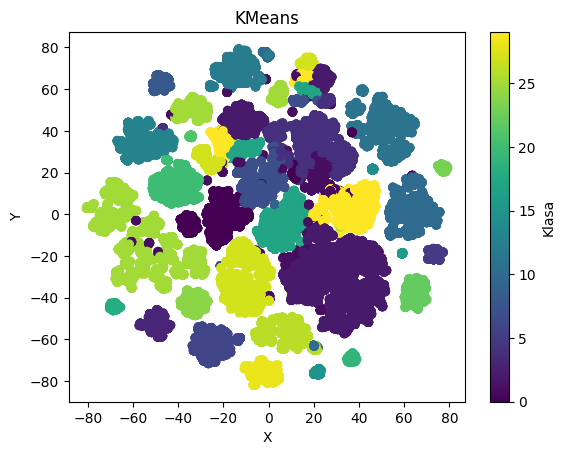

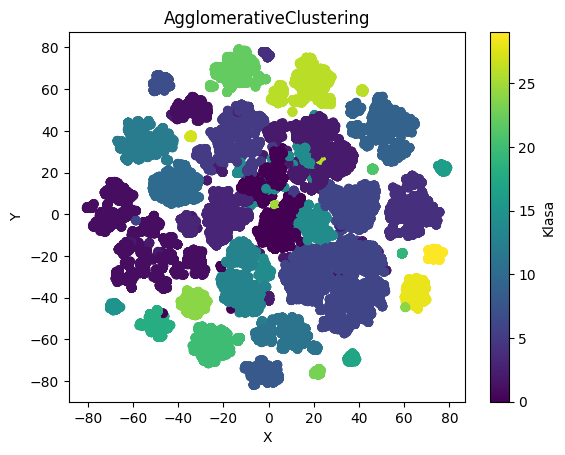

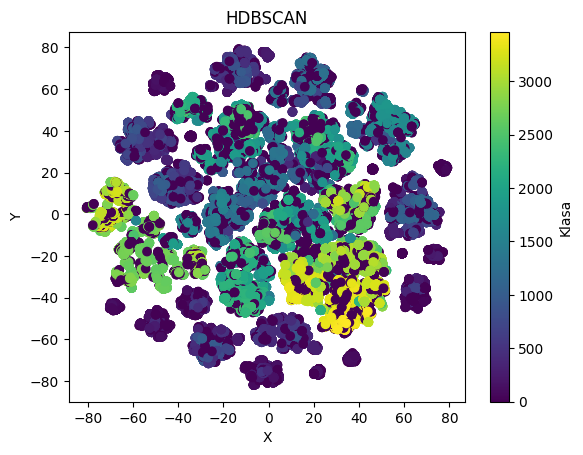

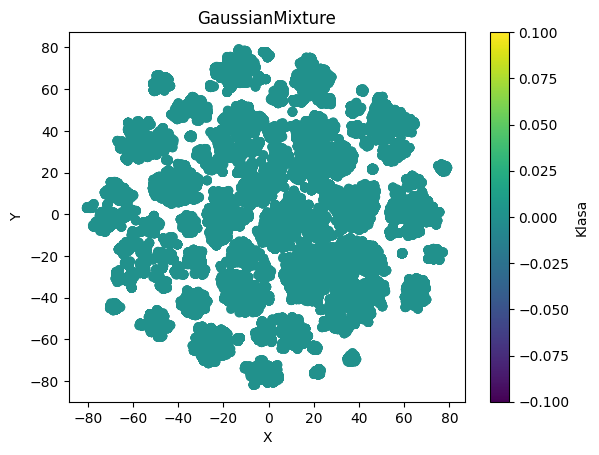

In [51]:
visualize_all(viz_pca_2d, 2, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

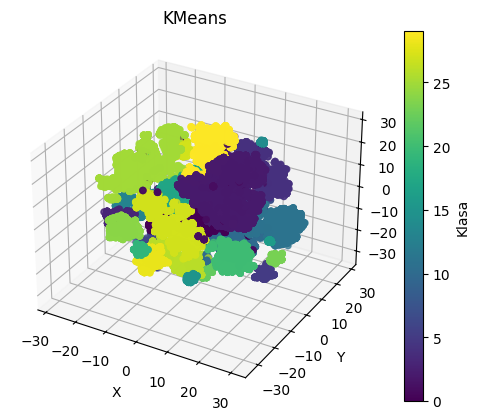

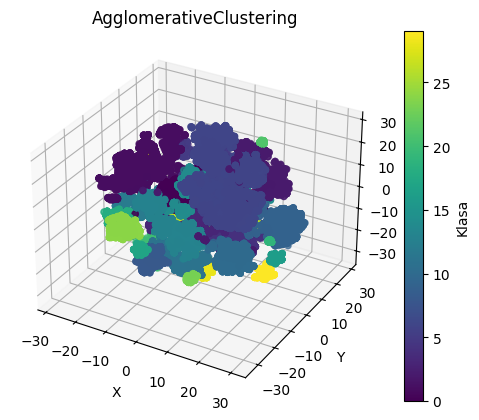

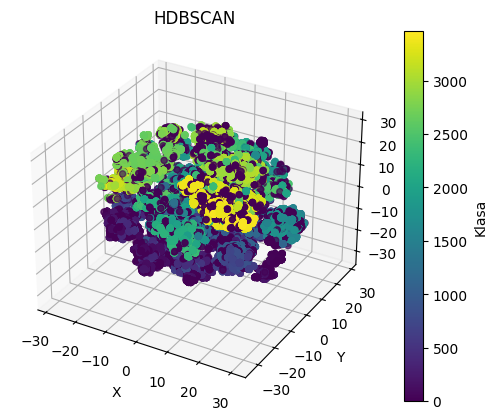

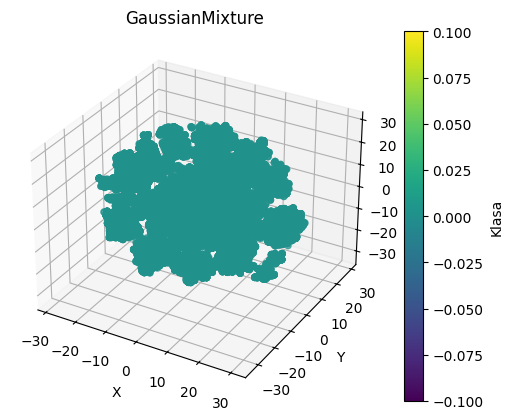

In [52]:
visualize_all(viz_pca_3d, 3, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

## Visualize LLE

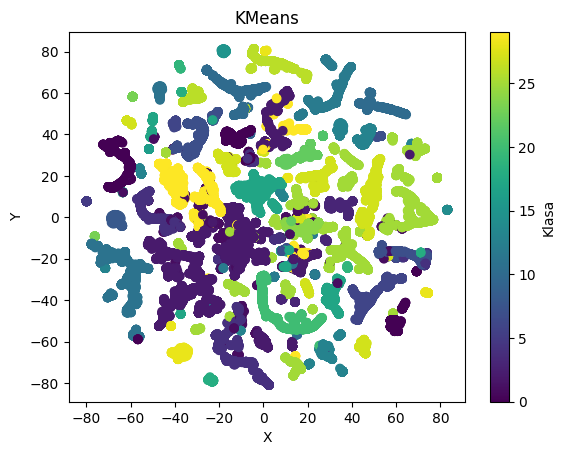

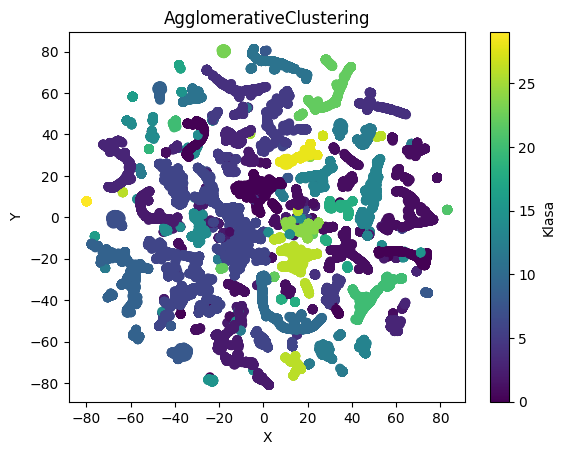

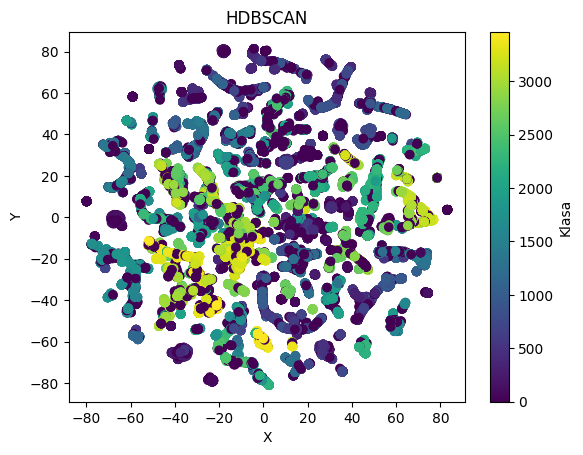

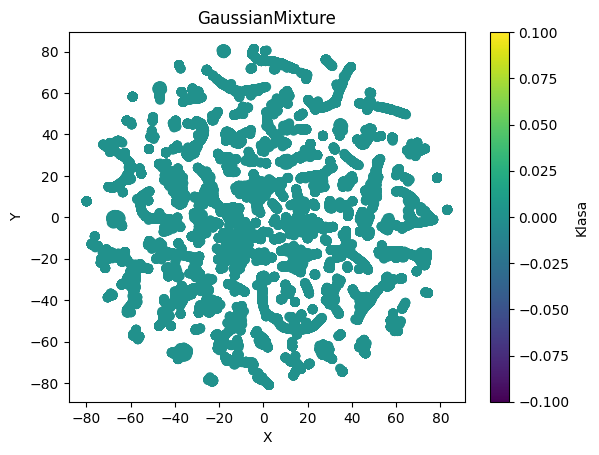

In [53]:
visualize_all(viz_lle_2d, 2, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

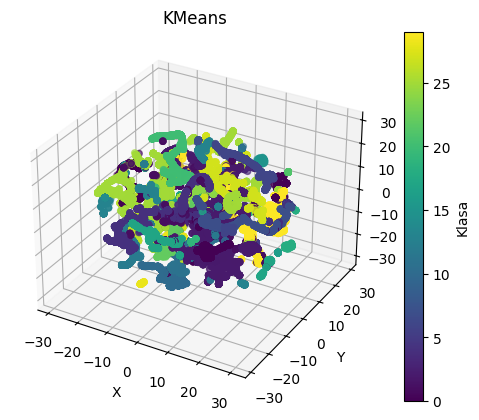

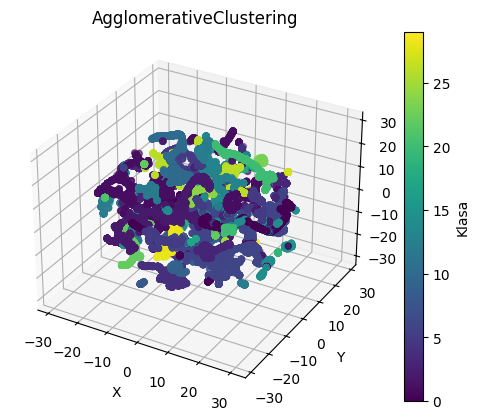

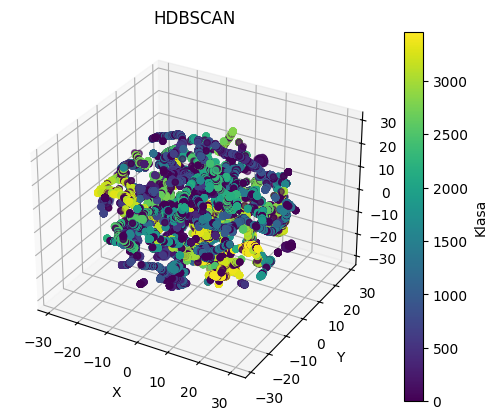

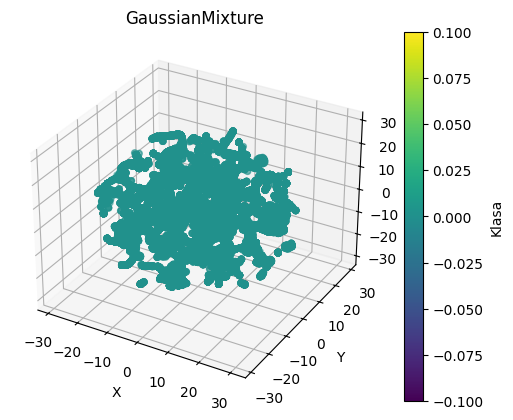

In [54]:
visualize_all(viz_lle_3d, 3, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

## KMeans Tune

C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  10 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  15 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  20 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  25 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  30 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  35 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  40 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  45 / 50


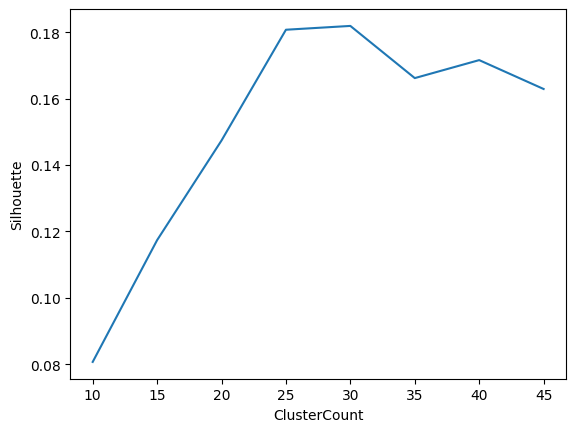

In [55]:
def silhouette_graph(data, min_k, max_k, step):
    rez = {}
    for i in range(min_k,max_k,step):
        km = KMeans(n_clusters=i)
        rez[i] = silhouette_score(data, km.fit_predict(data))
        print("Done: ", i, "/", max_k)
    df = pd.DataFrame(list(rez.items()), columns=['ClusterCount', 'Silhouette'])
    sns.lineplot(x='ClusterCount', y='Silhouette', data=df)

silhouette_graph(app_train_pca, 10, 50, 5)

C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  10 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  15 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  20 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  25 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  30 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  35 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  40 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  45 / 50


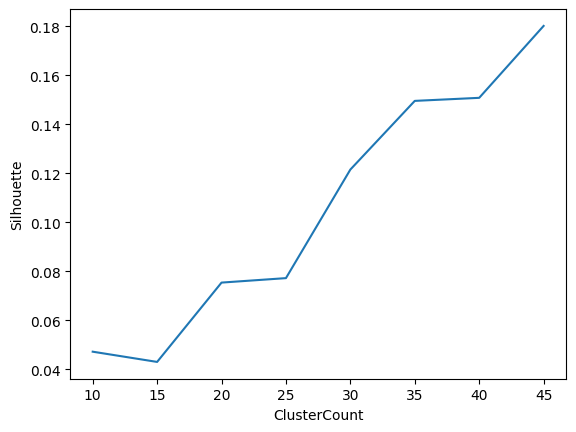

In [56]:
silhouette_graph(app_train_lle, 10, 50, 5)

## HDBSCAN

In [57]:
algs['HD'].labels_.max()

3461

In [58]:
algs_lle['HD'].labels_.max()

3589

## Agglomerative

In [59]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(algs['AC'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(algs_lle['AC'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Prediction

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1)

In [75]:
preds_pca_T = np.transpose(np.array(preds_pca))
preds_lle_T = np.transpose(np.array(preds_lle))

In [81]:
preds_lle_T

array([[  18,   26,   -1,    0],
       [  24,   20, 2169,    0],
       [  24,   20, 2169,    0],
       ...,
       [  18,   12,  779,    0],
       [   5,   12, 1949,    0],
       [  17,   23,  204,    0]], dtype=int64)

In [82]:
#preds_pca, preds_lle
#avg, last
k=0.2
test_len = int(k * len(preds_pca_T))
train_pca, test_pca = preds_pca_T[test_len:], preds_pca_T[:test_len]
train_lle, test_lle = preds_lle_T[test_len:], preds_lle_T[:test_len]
avg_train, avg_test = avg[test_len:], avg[:test_len] 
last_train, last_test = last[test_len:], last[:test_len] 

In [78]:
etc.fit(train_pca, avg_train)
print("PCA+AVG: ", etc.score(test_pca,avg_test))

PCA+AVG:  0.7131633356305996


In [79]:
etc.fit(train_pca, last_train)
print("PCA+LAST: ", etc.score(test_pca,last_test))

PCA+LAST:  0.42067539627842865


In [83]:
etc.fit(train_lle, avg_train)
print("LLE+AVG: ", etc.score(test_lle,avg_test))

LLE+AVG:  0.7135768435561681


In [84]:
etc.fit(train_lle, last_train)
print("LLE+LAST: ", etc.score(test_lle,last_test))

LLE+LAST:  0.39972432804962094
